# now do some ML using the web scraped data

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
from player_data_expansion import get_all_expanded_player_fight_data

In [13]:
# AWS integration getting file data
df_init = pd.read_csv("fight_data.csv").fillna(pd.NA)

In [14]:
df_init.head()

,Date,fighter1,fighter1_result,method_or_round,fighter2,Venue,Undercard fights,link,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
0,"Wednesday, 14 May 2025",Sam Goodman,Winner,"W, Round",Cesar Vaca Espinoza,"Hordern Pavilion, Sydney, New South Wales, Aus...",<NA>,https://box.live/fights/goodman-vs-espinoza/,19,0,0,19,1,1,169,NaN,0,0,2018,2018
1,"Sunday, 11 May 2025",Fernando Martinez,Winner,"W, Round",Kazuto Ioka,"Ota-City General Gymnasium, Tokyo, Japan",Hayato Tsutsumi Beat Jaime Arboleda (TKO 3),https://box.live/fights/martinez-vs-ioka-ii/,17,0,0,31,1,3,161,165.0,0,0,2017,2009
2,"Saturday, 10 May 2025",Anthony Cacace,Winner,"TKO, Round 9",Leigh Wood,"Motorpoint Arena, Nottingham, United Kingdom",Ezra Taylor Beat Troy Jones (UD 10) \nLiam Da...,https://box.live/fights/cacace-vs-wood/,23,0,1,28,0,3,178,170.0,35,61,2012,2011
3,"Saturday, 10 May 2025",Erickson Lubin,Winner,"TKO, Round 11",Ardreal Holmes,"Silver Spurs Arena, Kissimmee, FL, United States",Mayeli Flores Beat Nazarena Romero (SD 10),https://box.live/fights/lubin-vs-holmes/,26,0,2,17,0,0,180,188.0,69,35,2013,2016
4,"Saturday, 10 May 2025",Emanuel Navarrete,Winner,"TD, Round 8",Charly Suarez,"Pechanga Arena, San Diego, CA, United States",Raymond Muratalla Beat Zaur Abdullaev (UD 12)...,https://box.live/fights/navarrete-vs-suarez/,39,1,2,18,0,0,170,168.0,82,56,2012,2019


In [15]:
df_init.tail(10)

,Date,fighter1,fighter1_result,method_or_round,fighter2,Venue,Undercard fights,link,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
23,"Friday, 18 April 2025",Sergey Kovalev,Winner,"KO, Round 7",Artur Mann,"Yunost Arena, Chelyabinsk, Russian Federation",<NA>,https://box.live/fights/kovalev-vs-mann/,35,1,5,22,0,4,183,185.0,83,59,2009,2015
24,"Friday, 9 May 2025",Tommy Fury,Winner,"UD, Round 6",Kenan Hanjalic,"MTK Arena, Budapest, Hungary",Roman Fury Beat Josip Pehar (TKO 4),https://box.live/fights/fury-vs-hanjalic/,10,0,0,5,0,1,183,NaN,40,80,2018,2019
25,"Sunday, 4 May 2025",Naoya Inoue,Winner,"TKO, Round 8",Ramon Cardenas,"T-Mobile Arena, Las Vegas, United States",Rafael Espinoza Beat Edward Vazquez (TKO 7) \...,https://box.live/fights/inoue-vs-cardenas/,29,0,0,26,0,1,164,165.0,0,0,2012,2015
26,"Sunday, 11 May 2025",Fernando Martinez,Winner,"UD, Round 12",Kazuto Ioka,"Ota-City General Gymnasium, Tokyo, Japan",Hayato Tsutsumi Beat Jaime Arboleda (TKO 3),https://box.live/fights/martinez-vs-ioka-ii/,17,0,0,31,1,3,161,165.0,0,0,2017,2009
27,"Saturday, 10 May 2025",Anthony Cacace,Winner,"TKO, Round 9",Leigh Wood,"Motorpoint Arena, Nottingham, United Kingdom",Ezra Taylor Beat Troy Jones (UD 10) \nLiam Da...,https://box.live/fights/cacace-vs-wood/,23,0,1,28,0,3,178,170.0,35,61,2012,2011
28,"Saturday, 10 May 2025",Erickson Lubin,Winner,"TKO, Round 11",Ardreal Holmes,"Silver Spurs Arena, Kissimmee, FL, United States",Mayeli Flores Beat Nazarena Romero (SD 10),https://box.live/fights/lubin-vs-holmes/,26,0,2,17,0,0,180,188.0,69,35,2013,2016
29,"Saturday, 10 May 2025",Emanuel Navarrete,Winner,"TD, Round 8",Charly Suarez,"Pechanga Arena, San Diego, CA, United States",Raymond Muratalla Beat Zaur Abdullaev (UD 12)...,https://box.live/fights/navarrete-vs-suarez/,39,1,2,18,0,0,170,168.0,82,56,2012,2019
30,"Saturday, 10 May 2025",Souleymane Cissokho,Winner,"UD, Round 12",Egidijus Kavaliauskas,"Centre de Conference de Sipopo, Malabo, Equato...",Kevin Sadjo Beat Habib Ahmed (KO 3),https://box.live/fights/cissokho-vs-kavaliauskas/,17,0,0,24,1,2,179,175.0,53,79,1991,2013
31,"Friday, 9 May 2025",Dainier Pero,Winner,"UD, Round 10",Cesar Navarro,"Caribe Royale Orlando, Orlando, FL, United States",<NA>,https://box.live/fights/pero-vs-navarro/,10,0,0,13,0,2,188,183.0,80,85,2012,2017
32,"Friday, 9 May 2025",Andreas Katzourakis,Winner,"TKO, Round 7",Roberto Cruz,"Red Owl Boxing Arena, Houston, TX, United States",<NA>,https://box.live/fights/katzourakis-vs-cruz/,15,0,0,11,0,0,178,175.0,0,0,2018,2016


In [16]:
# ADD BASIC DATA TO SEE IF IT WORKS
df_init = pd.concat([df_init,pd.read_csv("fight_data_backup_basic.csv")], axis=0)
df_init.drop_duplicates(inplace=True)

### start cleaning

In [17]:
df_essentials = df_init.drop(columns=['link','Venue','Date','Undercard fights','fighter1','fighter2'])
df_essentials.head(2)

,fighter1_result,method_or_round,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
0,Winner,"W, Round",19.0,0.0,0.0,19.0,1.0,1.0,169.0,NaN,0.0,0.0,2018.0,2018.0
1,Winner,"W, Round",17.0,0.0,0.0,31.0,1.0,3.0,161.0,165.0,0.0,0.0,2017.0,2009.0


In [18]:
df_staged_cleaning = df_essentials.copy()
df_staged_cleaning.head(2)

,fighter1_result,method_or_round,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
0,Winner,"W, Round",19.0,0.0,0.0,19.0,1.0,1.0,169.0,NaN,0.0,0.0,2018.0,2018.0
1,Winner,"W, Round",17.0,0.0,0.0,31.0,1.0,3.0,161.0,165.0,0.0,0.0,2017.0,2009.0


In [19]:
df_staged_cleaning['method_or_round'] = df_staged_cleaning['method_or_round'].str.split(' ')

In [21]:
# last_rounds = [new_list[2] for new_list in df_staged_cleaning['method_or_round']][:]
# df_staged_cleaning['round'] = last_rounds round includes test bias

df_staged_cleaning.head()

,fighter1_result,method_or_round,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
0,Winner,"[W,, Round]",19.0,0.0,0.0,19.0,1.0,1.0,169.0,NaN,0.0,0.0,2018.0,2018.0
1,Winner,"[W,, Round]",17.0,0.0,0.0,31.0,1.0,3.0,161.0,165.0,0.0,0.0,2017.0,2009.0
2,Winner,"[TKO,, Round, 9]",23.0,0.0,1.0,28.0,0.0,3.0,178.0,170.0,35.0,61.0,2012.0,2011.0
3,Winner,"[TKO,, Round, 11]",26.0,0.0,2.0,17.0,0.0,0.0,180.0,188.0,69.0,35.0,2013.0,2016.0
4,Winner,"[TD,, Round, 8]",39.0,1.0,2.0,18.0,0.0,0.0,170.0,168.0,82.0,56.0,2012.0,2019.0


In [23]:
df_staged_cleaning = df_staged_cleaning.drop(columns='method_or_round')
df_staged_cleaning.head()

KeyError: "['method_or_round'] not found in axis"

### feature engineering swapped values + add to current values

In [24]:

df_staged_swapping = df_staged_cleaning.copy()

fighter2_wins_temp = df_staged_swapping['fighter2_record_wins'].copy()
fighter2_draws_temp = df_staged_swapping['fighter2_record_draws'].copy()
fighter2_losses_temp = df_staged_swapping['fighter2_record_losses'].copy()
fighter2_height_cm_temp = df_staged_swapping['fighter2_height_cm'].copy()
fighter2_ko_percentage_temp = df_staged_swapping['fighter2_ko_percentage'].copy()
fighter2_debut_temp = df_staged_swapping['fighter2_debut'].copy()

df_staged_swapping['fighter2_record_wins'] = df_staged_swapping['fighter1_record_wins']
df_staged_swapping['fighter2_record_draws'] = df_staged_swapping['fighter1_record_draws']
df_staged_swapping['fighter2_record_losses'] = df_staged_swapping['fighter1_record_losses']
df_staged_swapping['fighter2_height_cm'] = df_staged_swapping['fighter1_height_cm']
df_staged_swapping['fighter2_ko_percentage'] = df_staged_swapping['fighter1_ko_percentage']
df_staged_swapping['fighter2_debut'] = df_staged_swapping['fighter1_debut']

df_staged_swapping['fighter1_record_wins'] = fighter2_wins_temp
df_staged_swapping['fighter1_record_draws'] = fighter2_draws_temp
df_staged_swapping['fighter1_record_losses'] = fighter2_losses_temp
df_staged_swapping['fighter1_height_cm'] = fighter2_height_cm_temp
df_staged_swapping['fighter1_ko_percentage'] = fighter2_ko_percentage_temp
df_staged_swapping['fighter1_debut'] = fighter2_debut_temp



def reverse_results(rowval) : 
    if rowval == 'Winner' :
        return 'Loser'
    elif rowval == 'Loser' :
        return 'Winner'
    else :
        return 'Draw'
    
df_staged_swapping['fighter1_result'] = df_staged_swapping['fighter1_result'].apply(reverse_results)


concatenate the matrices

In [25]:
# df_encoded = pd.concat([df_staged_cleaning, df_staged_swapping], axis=0)
# df_encoded

could also feature engineer the ratio between fighters, such as fighter2/fighter1 for height

### encoding

In [26]:
# commented out. this is the original with no swapping
df_encoded = df_staged_cleaning.copy()

In [27]:
# WINNER = 0, LOSER = 1, DRAW = 2
def custom_encoder(value) :
    if value == 'Winner' :
        return 0
    elif value == 'Loser' :
        return 1
    else : return 2
df_encoded['fighter1_result'] = df_encoded['fighter1_result'].apply(custom_encoder)

In [28]:
df_encoded.shape

(36, 13)

In [29]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 0 to 11
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fighter1_result         36 non-null     int64  
 1   fighter1_record_wins    24 non-null     float64
 2   fighter1_record_draws   24 non-null     float64
 3   fighter1_record_losses  24 non-null     float64
 4   fighter2_record_wins    24 non-null     float64
 5   fighter2_record_draws   24 non-null     float64
 6   fighter2_record_losses  24 non-null     float64
 7   fighter1_height_cm      24 non-null     float64
 8   fighter2_height_cm      21 non-null     float64
 9   fighter1_ko_percentage  24 non-null     float64
 10  fighter2_ko_percentage  24 non-null     float64
 11  fighter1_debut          24 non-null     float64
 12  fighter2_debut          24 non-null     float64
dtypes: float64(12), int64(1)
memory usage: 3.9 KB


In [30]:
df_encoded = df_encoded.infer_objects()

df_encoded['fighter1_result'] = df_encoded['fighter1_result'].astype('category')

df_encoded['fighter1_record_wins'] = df_encoded['fighter1_record_wins'].astype('Int64')
df_encoded['fighter1_record_draws'] = df_encoded['fighter1_record_draws'].astype('Int64')
df_encoded['fighter1_record_losses'] = df_encoded['fighter1_record_losses'].astype('Int64')
df_encoded['fighter2_record_wins'] = df_encoded['fighter2_record_wins'].astype('Int64')
df_encoded['fighter2_record_draws'] = df_encoded['fighter2_record_draws'].astype('Int64')
df_encoded['fighter2_record_losses'] = df_encoded['fighter1_record_losses'].astype('Int64')
df_encoded['fighter1_height_cm'] = df_encoded['fighter2_height_cm'].astype('Int64')
df_encoded['fighter2_height_cm'] = df_encoded['fighter2_height_cm'].astype('Int64')
df_encoded['fighter1_ko_percentage'] = df_encoded['fighter1_ko_percentage'].astype('Int64')
df_encoded['fighter2_ko_percentage'] = df_encoded['fighter2_ko_percentage'].astype('Int64')
# df_encoded['round'] = df_encoded['round'].astype('Int64') round includes test bias
df_encoded['fighter1_debut'] = df_encoded['fighter1_debut'].astype('Int64')
df_encoded['fighter2_debut'] = df_encoded['fighter1_debut'].astype('Int64')

In [31]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 0 to 11
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   fighter1_result         36 non-null     category
 1   fighter1_record_wins    24 non-null     Int64   
 2   fighter1_record_draws   24 non-null     Int64   
 3   fighter1_record_losses  24 non-null     Int64   
 4   fighter2_record_wins    24 non-null     Int64   
 5   fighter2_record_draws   24 non-null     Int64   
 6   fighter2_record_losses  24 non-null     Int64   
 7   fighter1_height_cm      21 non-null     Int64   
 8   fighter2_height_cm      21 non-null     Int64   
 9   fighter1_ko_percentage  24 non-null     Int64   
 10  fighter2_ko_percentage  24 non-null     Int64   
 11  fighter1_debut          24 non-null     Int64   
 12  fighter2_debut          24 non-null     Int64   
dtypes: Int64(12), category(1)
memory usage: 4.2 KB


In [32]:
df_encoded.describe()

,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
count,24.0,24.0,24.0,24.0,24.0,24.0,21.0,21.0,24.0,24.0,24.0,24.0
mean,24.041667,0.25,1.083333,20.375,0.333333,1.083333,173.142857,173.142857,32.958333,30.875,2013.541667,2013.541667
std,12.85193,0.53161,1.47196,6.472769,0.481543,1.47196,8.702216,8.702216,35.877181,33.52003,6.534052,6.534052
min,8.0,0.0,0.0,5.0,0.0,0.0,160.0,160.0,0.0,0.0,1991.0,1991.0
25%,15.0,0.0,0.0,16.75,0.0,0.0,166.0,166.0,0.0,0.0,2011.75,2011.75
50%,21.0,0.0,0.0,21.5,0.0,0.0,173.0,173.0,17.5,17.5,2012.5,2012.5
75%,31.0,0.0,2.0,24.5,1.0,2.0,182.0,182.0,70.25,59.5,2018.0,2018.0
max,62.0,2.0,5.0,31.0,1.0,5.0,188.0,188.0,83.0,85.0,2022.0,2022.0


### tt split

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X = df_encoded.drop(columns=['fighter1_result', "fighter1_ko_percentage", 'fighter2_ko_percentage'])
y = df_encoded['fighter1_result']
y.unique()

[0, 1, 2]
Categories (3, int64): [0, 1, 2]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80) # tweak to maker sure that y values contain wins, losses, and draws. ts = .2 and rs =  66
print(y_train.unique())
print(y_test.unique())

[0, 1, 2]
Categories (3, int64): [0, 1, 2]
[0, 2]
Categories (3, int64): [0, 1, 2]


## TRAIN MODEL - XGBoost First

In [36]:
from xgboost import XGBClassifier

In [37]:
xgbc = XGBClassifier(
    objective='multi:softmax',
    random_state=42,
    num_class=3,
    verbosity=1
)

In [38]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [39]:
y_train = encoder.fit_transform(y_train)

In [40]:
# compute sample weight based on class frequency
class_weights = dict(enumerate(len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))))
sample_weight = np.array([class_weights[label] for label in y_train])
sample_weight

array([0.36231884, 0.36231884, 0.36231884, 0.36231884, 0.36231884,
       8.33333333, 0.36231884, 0.36231884, 0.36231884, 0.36231884,
       0.36231884, 0.36231884, 0.36231884, 8.33333333, 0.36231884,
       0.36231884, 0.36231884, 0.36231884, 0.36231884, 0.36231884,
       0.36231884, 0.36231884, 0.36231884, 0.36231884, 0.36231884])

In [41]:
# # no class weighting
# xgbc.fit(X_train, y_train)

# class weighting
xgbc.fit(X_train, y_train, sample_weight=sample_weight)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=3, ...)

In [42]:
xgbc_preds = xgbc.predict(X_test)
xgbc_preds = encoder.inverse_transform(xgbc_preds)

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [44]:
print(accuracy_score(y_test, xgbc_preds))

0.9090909090909091


In [45]:
print(confusion_matrix(y_test, xgbc_preds))

[[10  0]
 [ 1  0]]


In [46]:
print(classification_report(y_test, xgbc_preds))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           2       0.00      0.00      0.00         1

    accuracy                           0.91        11
   macro avg       0.45      0.50      0.48        11
weighted avg       0.83      0.91      0.87        11



c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
xgbc_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

### grid search cross validated + XGBoost Classifier - same rseult as initial one

In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
eval_set = [(X, y)] # validation set for early stopping

In [50]:
xgbc_model2 = XGBClassifier(
    objective='multi:softmax',
    random_state=42,
    num_class=3,
    verbosity=1,
    eval_metric="mlogloss"
)

In [51]:
param_grid = {
    "subsample":[0.75, 1],
     "colsample_bytree":[0.75, 1],
     "max_depth":[2, 6],
     "min_child_weight":[1, 2,3],
     "learning_rate":[1, 0.1, 0.01],
}

In [52]:
xgbc_grid = GridSearchCV(
    xgbc_model2,
    param_grid,
    cv=3,
    scoring="f1"
)

In [53]:
xgbc_grid.fit(X_train,y_train,eval_set=eval_set,verbose=1)

[0]	validation_0-mlogloss:0.45336
[1]	validation_0-mlogloss:0.35171
[2]	validation_0-mlogloss:0.33636
[3]	validation_0-mlogloss:0.32203
[4]	validation_0-mlogloss:0.31903
[5]	validation_0-mlogloss:0.31273
[6]	validation_0-mlogloss:0.31292
[7]	validation_0-mlogloss:0.31513
[8]	validation_0-mlogloss:0.31634
[9]	validation_0-mlogloss:0.31989
[10]	validation_0-mlogloss:0.32278
[11]	validation_0-mlogloss:0.33414
[12]	validation_0-mlogloss:0.33332
[13]	validation_0-mlogloss:0.33432
[14]	validation_0-mlogloss:0.33526
[15]	validation_0-mlogloss:0.33665
[16]	validation_0-mlogloss:0.33827
[17]	validation_0-mlogloss:0.34087
[18]	validation_0-mlogloss:0.34370
[19]	validation_0-mlogloss:0.34484
[20]	validation_0-mlogloss:0.34654
[21]	validation_0-mlogloss:0.34820
[22]	validation_0-mlogloss:0.34837
[23]	validation_0-mlogloss:0.34972
[24]	validation_0-mlogloss:0.35028
[25]	validation_0-mlogloss:0.35400
[26]	validation_0-mlogloss:0.35495
[27]	validation_0-mlogloss:0.35736
[28]	validation_0-mlogloss:0.3

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[56]	validation_0-mlogloss:0.38760
[57]	validation_0-mlogloss:0.38690
[58]	validation_0-mlogloss:0.38741
[59]	validation_0-mlogloss:0.38820
[60]	validation_0-mlogloss:0.39103
[61]	validation_0-mlogloss:0.39078
[62]	validation_0-mlogloss:0.39214
[63]	validation_0-mlogloss:0.39459
[64]	validation_0-mlogloss:0.39347
[65]	validation_0-mlogloss:0.39157


[66]	validation_0-mlogloss:0.38935
[67]	validation_0-mlogloss:0.38797
[68]	validation_0-mlogloss:0.39036
[69]	validation_0-mlogloss:0.38939
[70]	validation_0-mlogloss:0.39165
[71]	validation_0-mlogloss:0.39191
[72]	validation_0-mlogloss:0.39312
[73]	validation_0-mlogloss:0.39312
[74]	validation_0-mlogloss:0.39326
[75]	validation_0-mlogloss:0.39352
[76]	validation_0-mlogloss:0.39423
[77]	validation_0-mlogloss:0.39711
[78]	validation_0-mlogloss:0.39647
[79]	validation_0-mlogloss:0.39694
[80]	validation_0-mlogloss:0.39664
[81]	validation_0-mlogloss:0.39856
[82]	validation_0-mlogloss:0.39864
[83]	validation_0-mlogloss:0.39886
[84]	validation_0-mlogloss:0.39944
[85]	validation_0-mlogloss:0.40066
[86]	validation_0-mlogloss:0.40319
[87]	validation_0-mlogloss:0.40625
[88]	validation_0-mlogloss:0.40708
[89]	validation_0-mlogloss:0.40783
[90]	validation_0-mlogloss:0.41078
[91]	validation_0-mlogloss:0.40941
[92]	validation_0-mlogloss:0.41008
[93]	validation_0-mlogloss:0.41173
[94]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[97]	validation_0-mlogloss:0.27413
[98]	validation_0-mlogloss:0.27183
[99]	validation_0-mlogloss:0.27297
[0]	validation_0-mlogloss:0.42886
[1]	validation_0-mlogloss:0.33360
[2]	validation_0-mlogloss:0.31901
[3]	validation_0-mlogloss:0.33057
[4]	validation_0-mlogloss:0.32772
[5]	validation_0-mlogloss:0.32368
[6]	validation_0-mlogloss:0.32542
[7]	validation_0-mlogloss:0.32738
[8]	validation_0-mlogloss:0.32936
[9]	validation_0-mlogloss:0.33131
[10]	validation_0-mlogloss:0.33320
[11]	validation_0-mlogloss:0.33504
[12]	validation_0-mlogloss:0.33683
[13]	validation_0-mlogloss:0.33857
[14]	validation_0-mlogloss:0.34027
[15]	validation_0-mlogloss:0.34192
[16]	validation_0-mlogloss:0.34352
[17]	validation_0-mlogloss:0.34508
[18]	validation_0-mlogloss:0.34661
[19]	validation_0-mlogloss:0.34809
[20]	validation_0-mlogloss:0.34954
[21]	validation_0-mlogloss:0.35096
[22]	validation_0-mlogloss:0.35234
[23]	validation_0-mlogloss:0.35369
[24]	validation_0-mlogloss:0.35501
[25]	validation_0-mlogloss:0.3

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[97]	validation_0-mlogloss:0.41125
[98]	validation_0-mlogloss:0.41173
[99]	validation_0-mlogloss:0.41221
[0]	validation_0-mlogloss:0.47185
[1]	validation_0-mlogloss:0.34005
[2]	validation_0-mlogloss:0.29195
[3]	validation_0-mlogloss:0.27608
[4]	validation_0-mlogloss:0.27212
[5]	validation_0-mlogloss:0.26786
[6]	validation_0-mlogloss:0.26599
[7]	validation_0-mlogloss:0.26412
[8]	validation_0-mlogloss:0.26347
[9]	validation_0-mlogloss:0.26565
[10]	validation_0-mlogloss:0.26573
[11]	validation_0-mlogloss:0.26419
[12]	validation_0-mlogloss:0.26428
[13]	validation_0-mlogloss:0.26304
[14]	validation_0-mlogloss:0.26314
[15]	validation_0-mlogloss:0.26212
[16]	validation_0-mlogloss:0.26222
[17]	validation_0-mlogloss:0.26137
[18]	validation_0-mlogloss:0.25856
[19]	validation_0-mlogloss:0.26025
[20]	validation_0-mlogloss:0.26034
[21]	validation_0-mlogloss:0.26255
[22]	validation_0-mlogloss:0.26307
[23]	validation_0-mlogloss:0.26244
[24]	validation_0-mlogloss:0.26446
[25]	validation_0-mlogloss:0.2

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[77]	validation_0-mlogloss:0.27128
[78]	validation_0-mlogloss:0.27138
[79]	validation_0-mlogloss:0.27006
[80]	validation_0-mlogloss:0.26993
[81]	validation_0-mlogloss:0.27079
[82]	validation_0-mlogloss:0.27086
[83]	validation_0-mlogloss:0.27078
[84]	validation_0-mlogloss:0.27082
[85]	validation_0-mlogloss:0.27075
[86]	validation_0-mlogloss:0.27078
[87]	validation_0-mlogloss:0.27070
[88]	validation_0-mlogloss:0.27073
[89]	validation_0-mlogloss:0.27066
[90]	validation_0-mlogloss:0.27069
[91]	validation_0-mlogloss:0.26972
[92]	validation_0-mlogloss:0.27038
[93]	validation_0-mlogloss:0.26949
[94]	validation_0-mlogloss:0.26937
[95]	validation_0-mlogloss:0.26939
[96]	validation_0-mlogloss:0.26930
[97]	validation_0-mlogloss:0.26933
[98]	validation_0-mlogloss:0.26925
[99]	validation_0-mlogloss:0.26985
[0]	validation_0-mlogloss:0.46095
[1]	validation_0-mlogloss:0.37061
[2]	validation_0-mlogloss:0.35323
[3]	validation_0-mlogloss:0.34510
[4]	validation_0-mlogloss:0.34308
[5]	validation_0-mlogloss

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[19]	validation_0-mlogloss:0.31036
[20]	validation_0-mlogloss:0.31436
[21]	validation_0-mlogloss:0.30779
[22]	validation_0-mlogloss:0.30612
[23]	validation_0-mlogloss:0.30612
[24]	validation_0-mlogloss:0.30495
[25]	validation_0-mlogloss:0.30468
[26]	validation_0-mlogloss:0.30629
[27]	validation_0-mlogloss:0.30499
[28]	validation_0-mlogloss:0.30468
[29]	validation_0-mlogloss:0.30578
[30]	validation_0-mlogloss:0.30495
[31]	validation_0-mlogloss:0.30495
[32]	validation_0-mlogloss:0.30664
[33]	validation_0-mlogloss:0.31110
[34]	validation_0-mlogloss:0.31148
[35]	validation_0-mlogloss:0.31096
[36]	validation_0-mlogloss:0.31681
[37]	validation_0-mlogloss:0.31565
[38]	validation_0-mlogloss:0.31549
[39]	validation_0-mlogloss:0.30929
[40]	validation_0-mlogloss:0.31123
[41]	validation_0-mlogloss:0.30675
[42]	validation_0-mlogloss:0.31023
[43]	validation_0-mlogloss:0.31295
[44]	validation_0-mlogloss:0.30474
[45]	validation_0-mlogloss:0.30690
[46]	validation_0-mlogloss:0.31121
[47]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:0.35537
[2]	validation_0-mlogloss:0.31394
[3]	validation_0-mlogloss:0.30273
[4]	validation_0-mlogloss:0.30101
[5]	validation_0-mlogloss:0.30004
[6]	validation_0-mlogloss:0.29947
[7]	validation_0-mlogloss:0.29914
[8]	validation_0-mlogloss:0.29894
[9]	validation_0-mlogloss:0.29881
[10]	validation_0-mlogloss:0.29874
[11]	validation_0-mlogloss:0.29869
[12]	validation_0-mlogloss:0.29867
[13]	validation_0-mlogloss:0.29865
[14]	validation_0-mlogloss:0.29864
[15]	validation_0-mlogloss:0.29863
[16]	validation_0-mlogloss:0.29863
[17]	validation_0-mlogloss:0.29862
[18]	validation_0-mlogloss:0.29862
[19]	validation_0-mlogloss:0.29862
[20]	validation_0-mlogloss:0.29862
[21]	validation_0-mlogloss:0.29862
[22]	validation_0-mlogloss:0.29862
[23]	validation_0-mlogloss:0.29862
[24]	validation_0-mlogloss:0.29862
[25]	validation_0-mlogloss:0.29862
[26]	validation_0-mlogloss:0.29862
[27]	validation_0-mlogloss:0.29862
[28]	validation_0-mlogloss:0.29862
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:0.39525
[2]	validation_0-mlogloss:0.37826
[3]	validation_0-mlogloss:0.37097
[4]	validation_0-mlogloss:0.36876
[5]	validation_0-mlogloss:0.36641
[6]	validation_0-mlogloss:0.35429
[7]	validation_0-mlogloss:0.35429
[8]	validation_0-mlogloss:0.35666
[9]	validation_0-mlogloss:0.35821
[10]	validation_0-mlogloss:0.36084
[11]	validation_0-mlogloss:0.34898
[12]	validation_0-mlogloss:0.34898
[13]	validation_0-mlogloss:0.34898
[14]	validation_0-mlogloss:0.34898
[15]	validation_0-mlogloss:0.34898
[16]	validation_0-mlogloss:0.34898
[17]	validation_0-mlogloss:0.34898
[18]	validation_0-mlogloss:0.35126
[19]	validation_0-mlogloss:0.35126
[20]	validation_0-mlogloss:0.35126
[21]	validation_0-mlogloss:0.35126
[22]	validation_0-mlogloss:0.35126
[23]	validation_0-mlogloss:0.35126
[24]	validation_0-mlogloss:0.35126
[25]	validation_0-mlogloss:0.34564
[26]	validation_0-mlogloss:0.34564
[27]	validation_0-mlogloss:0.34564
[28]	validation_0-mlogloss:0.34564
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[12]	validation_0-mlogloss:0.34854
[13]	validation_0-mlogloss:0.34850
[14]	validation_0-mlogloss:0.34848
[15]	validation_0-mlogloss:0.34847
[16]	validation_0-mlogloss:0.34846
[17]	validation_0-mlogloss:0.34845
[18]	validation_0-mlogloss:0.34845
[19]	validation_0-mlogloss:0.34845
[20]	validation_0-mlogloss:0.34845
[21]	validation_0-mlogloss:0.34844
[22]	validation_0-mlogloss:0.34844
[23]	validation_0-mlogloss:0.34844
[24]	validation_0-mlogloss:0.34844
[25]	validation_0-mlogloss:0.34844
[26]	validation_0-mlogloss:0.34844
[27]	validation_0-mlogloss:0.34844
[28]	validation_0-mlogloss:0.34844
[29]	validation_0-mlogloss:0.34844
[30]	validation_0-mlogloss:0.34844
[31]	validation_0-mlogloss:0.34844
[32]	validation_0-mlogloss:0.34844
[33]	validation_0-mlogloss:0.34844
[34]	validation_0-mlogloss:0.34844
[35]	validation_0-mlogloss:0.34844
[36]	validation_0-mlogloss:0.34844
[37]	validation_0-mlogloss:0.34844
[38]	validation_0-mlogloss:0.34844
[39]	validation_0-mlogloss:0.34844
[40]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[6]	validation_0-mlogloss:0.28806
[7]	validation_0-mlogloss:0.28433
[8]	validation_0-mlogloss:0.28536
[9]	validation_0-mlogloss:0.28329
[10]	validation_0-mlogloss:0.27743
[11]	validation_0-mlogloss:0.26393
[12]	validation_0-mlogloss:0.26658
[13]	validation_0-mlogloss:0.26684
[14]	validation_0-mlogloss:0.27115
[15]	validation_0-mlogloss:0.26471
[16]	validation_0-mlogloss:0.26360
[17]	validation_0-mlogloss:0.26802
[18]	validation_0-mlogloss:0.26494
[19]	validation_0-mlogloss:0.26777
[20]	validation_0-mlogloss:0.26707
[21]	validation_0-mlogloss:0.26583
[22]	validation_0-mlogloss:0.26580
[23]	validation_0-mlogloss:0.26584
[24]	validation_0-mlogloss:0.26605
[25]	validation_0-mlogloss:0.26474
[26]	validation_0-mlogloss:0.26487
[27]	validation_0-mlogloss:0.26556
[28]	validation_0-mlogloss:0.26646
[29]	validation_0-mlogloss:0.26798
[30]	validation_0-mlogloss:0.26853
[31]	validation_0-mlogloss:0.27282
[32]	validation_0-mlogloss:0.27394
[33]	validation_0-mlogloss:0.27681
[34]	validation_0-mloglo

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:0.34005
[2]	validation_0-mlogloss:0.29195
[3]	validation_0-mlogloss:0.27608
[4]	validation_0-mlogloss:0.27212
[5]	validation_0-mlogloss:0.26786
[6]	validation_0-mlogloss:0.26599
[7]	validation_0-mlogloss:0.26412
[8]	validation_0-mlogloss:0.26347
[9]	validation_0-mlogloss:0.26565
[10]	validation_0-mlogloss:0.26573
[11]	validation_0-mlogloss:0.26419
[12]	validation_0-mlogloss:0.26428
[13]	validation_0-mlogloss:0.26304
[14]	validation_0-mlogloss:0.26314
[15]	validation_0-mlogloss:0.26212
[16]	validation_0-mlogloss:0.26222
[17]	validation_0-mlogloss:0.26137
[18]	validation_0-mlogloss:0.25856
[19]	validation_0-mlogloss:0.26025
[20]	validation_0-mlogloss:0.26034
[21]	validation_0-mlogloss:0.26255
[22]	validation_0-mlogloss:0.26307
[23]	validation_0-mlogloss:0.26244
[24]	validation_0-mlogloss:0.26446
[25]	validation_0-mlogloss:0.26508
[26]	validation_0-mlogloss:0.26698
[27]	validation_0-mlogloss:0.26711
[28]	validation_0-mlogloss:0.26754
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.36534
[2]	validation_0-mlogloss:0.32509
[3]	validation_0-mlogloss:0.31274
[4]	validation_0-mlogloss:0.31550
[5]	validation_0-mlogloss:0.31753
[6]	validation_0-mlogloss:0.31034
[7]	validation_0-mlogloss:0.31502
[8]	validation_0-mlogloss:0.31492
[9]	validation_0-mlogloss:0.31513
[10]	validation_0-mlogloss:0.31566
[11]	validation_0-mlogloss:0.30792
[12]	validation_0-mlogloss:0.30984
[13]	validation_0-mlogloss:0.30611
[14]	validation_0-mlogloss:0.30827
[15]	validation_0-mlogloss:0.30581
[16]	validation_0-mlogloss:0.30581
[17]	validation_0-mlogloss:0.30581
[18]	validation_0-mlogloss:0.30764
[19]	validation_0-mlogloss:0.31036
[20]	validation_0-mlogloss:0.31436
[21]	validation_0-mlogloss:0.30779
[22]	validation_0-mlogloss:0.30612
[23]	validation_0-mlogloss:0.30612
[24]	validation_0-mlogloss:0.30495
[25]	validation_0-mlogloss:0.30468
[26]	validation_0-mlogloss:0.30629
[27]	validation_0-mlogloss:0.30499
[28]	validation_0-mlogloss:0.30468
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:0.35537
[2]	validation_0-mlogloss:0.31394
[3]	validation_0-mlogloss:0.30273
[4]	validation_0-mlogloss:0.30101
[5]	validation_0-mlogloss:0.30004
[6]	validation_0-mlogloss:0.29947
[7]	validation_0-mlogloss:0.29914
[8]	validation_0-mlogloss:0.29894
[9]	validation_0-mlogloss:0.29881
[10]	validation_0-mlogloss:0.29874
[11]	validation_0-mlogloss:0.29869
[12]	validation_0-mlogloss:0.29867
[13]	validation_0-mlogloss:0.29865
[14]	validation_0-mlogloss:0.29864
[15]	validation_0-mlogloss:0.29863
[16]	validation_0-mlogloss:0.29863
[17]	validation_0-mlogloss:0.29862
[18]	validation_0-mlogloss:0.29862
[19]	validation_0-mlogloss:0.29862
[20]	validation_0-mlogloss:0.29862
[21]	validation_0-mlogloss:0.29862
[22]	validation_0-mlogloss:0.29862
[23]	validation_0-mlogloss:0.29862
[24]	validation_0-mlogloss:0.29862
[25]	validation_0-mlogloss:0.29862
[26]	validation_0-mlogloss:0.29862
[27]	validation_0-mlogloss:0.29862
[28]	validation_0-mlogloss:0.29862
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[92]	validation_0-mlogloss:0.35261
[93]	validation_0-mlogloss:0.35261
[94]	validation_0-mlogloss:0.35261
[95]	validation_0-mlogloss:0.35261
[96]	validation_0-mlogloss:0.35261
[97]	validation_0-mlogloss:0.35261
[98]	validation_0-mlogloss:0.35261
[99]	validation_0-mlogloss:0.35261
[0]	validation_0-mlogloss:0.48845
[1]	validation_0-mlogloss:0.39525
[2]	validation_0-mlogloss:0.37826
[3]	validation_0-mlogloss:0.37097
[4]	validation_0-mlogloss:0.36876
[5]	validation_0-mlogloss:0.36641
[6]	validation_0-mlogloss:0.35429
[7]	validation_0-mlogloss:0.35429
[8]	validation_0-mlogloss:0.35666
[9]	validation_0-mlogloss:0.35821
[10]	validation_0-mlogloss:0.36084
[11]	validation_0-mlogloss:0.34898
[12]	validation_0-mlogloss:0.34898
[13]	validation_0-mlogloss:0.34898
[14]	validation_0-mlogloss:0.34898
[15]	validation_0-mlogloss:0.34898
[16]	validation_0-mlogloss:0.34898
[17]	validation_0-mlogloss:0.34898
[18]	validation_0-mlogloss:0.35126
[19]	validation_0-mlogloss:0.35126
[20]	validation_0-mlogloss:0.3

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[8]	validation_0-mlogloss:0.35062
[9]	validation_0-mlogloss:0.35062
[10]	validation_0-mlogloss:0.35062
[11]	validation_0-mlogloss:0.35062
[12]	validation_0-mlogloss:0.35062
[13]	validation_0-mlogloss:0.35062
[14]	validation_0-mlogloss:0.35062
[15]	validation_0-mlogloss:0.35062
[16]	validation_0-mlogloss:0.35062
[17]	validation_0-mlogloss:0.35062
[18]	validation_0-mlogloss:0.35062
[19]	validation_0-mlogloss:0.35062
[20]	validation_0-mlogloss:0.35062
[21]	validation_0-mlogloss:0.35062
[22]	validation_0-mlogloss:0.35062
[23]	validation_0-mlogloss:0.35062
[24]	validation_0-mlogloss:0.35062
[25]	validation_0-mlogloss:0.35062
[26]	validation_0-mlogloss:0.35062
[27]	validation_0-mlogloss:0.35062
[28]	validation_0-mlogloss:0.35062
[29]	validation_0-mlogloss:0.35062
[30]	validation_0-mlogloss:0.35062
[31]	validation_0-mlogloss:0.35062
[32]	validation_0-mlogloss:0.35062
[33]	validation_0-mlogloss:0.35062
[34]	validation_0-mlogloss:0.35062
[35]	validation_0-mlogloss:0.35062
[36]	validation_0-mlog

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[4]	validation_0-mlogloss:0.73078
[5]	validation_0-mlogloss:0.68220
[6]	validation_0-mlogloss:0.64042
[7]	validation_0-mlogloss:0.60630
[8]	validation_0-mlogloss:0.57413
[9]	validation_0-mlogloss:0.54686
[10]	validation_0-mlogloss:0.52403
[11]	validation_0-mlogloss:0.50317
[12]	validation_0-mlogloss:0.48179
[13]	validation_0-mlogloss:0.46330
[14]	validation_0-mlogloss:0.44722
[15]	validation_0-mlogloss:0.43345
[16]	validation_0-mlogloss:0.42052
[17]	validation_0-mlogloss:0.40880
[18]	validation_0-mlogloss:0.39943
[19]	validation_0-mlogloss:0.39119
[20]	validation_0-mlogloss:0.38236
[21]	validation_0-mlogloss:0.37495
[22]	validation_0-mlogloss:0.36735
[23]	validation_0-mlogloss:0.36318
[24]	validation_0-mlogloss:0.35880
[25]	validation_0-mlogloss:0.35511
[26]	validation_0-mlogloss:0.35004
[27]	validation_0-mlogloss:0.34611
[28]	validation_0-mlogloss:0.34310
[29]	validation_0-mlogloss:0.34104
[30]	validation_0-mlogloss:0.33850
[31]	validation_0-mlogloss:0.33599
[32]	validation_0-mlogloss

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[11]	validation_0-mlogloss:0.48078
[12]	validation_0-mlogloss:0.46144
[13]	validation_0-mlogloss:0.44444
[14]	validation_0-mlogloss:0.42942
[15]	validation_0-mlogloss:0.41617
[16]	validation_0-mlogloss:0.40450
[17]	validation_0-mlogloss:0.39326
[18]	validation_0-mlogloss:0.38422
[19]	validation_0-mlogloss:0.37633
[20]	validation_0-mlogloss:0.36939
[21]	validation_0-mlogloss:0.36334
[22]	validation_0-mlogloss:0.35809
[23]	validation_0-mlogloss:0.35254
[24]	validation_0-mlogloss:0.34867
[25]	validation_0-mlogloss:0.34534
[26]	validation_0-mlogloss:0.34254
[27]	validation_0-mlogloss:0.33916
[28]	validation_0-mlogloss:0.33767
[29]	validation_0-mlogloss:0.33609
[30]	validation_0-mlogloss:0.33527
[31]	validation_0-mlogloss:0.33325
[32]	validation_0-mlogloss:0.33296
[33]	validation_0-mlogloss:0.33146
[34]	validation_0-mlogloss:0.33070
[35]	validation_0-mlogloss:0.33065
[36]	validation_0-mlogloss:0.32976
[37]	validation_0-mlogloss:0.32977
[38]	validation_0-mlogloss:0.32852
[39]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[12]	validation_0-mlogloss:0.49868
[13]	validation_0-mlogloss:0.48180
[14]	validation_0-mlogloss:0.46527
[15]	validation_0-mlogloss:0.45252
[16]	validation_0-mlogloss:0.44162
[17]	validation_0-mlogloss:0.43266
[18]	validation_0-mlogloss:0.42277
[19]	validation_0-mlogloss:0.41592
[20]	validation_0-mlogloss:0.40935
[21]	validation_0-mlogloss:0.40131
[22]	validation_0-mlogloss:0.39453
[23]	validation_0-mlogloss:0.38965
[24]	validation_0-mlogloss:0.38529
[25]	validation_0-mlogloss:0.38046
[26]	validation_0-mlogloss:0.37652
[27]	validation_0-mlogloss:0.37313
[28]	validation_0-mlogloss:0.37011
[29]	validation_0-mlogloss:0.36768
[30]	validation_0-mlogloss:0.36532
[31]	validation_0-mlogloss:0.36387
[32]	validation_0-mlogloss:0.36133
[33]	validation_0-mlogloss:0.35932
[34]	validation_0-mlogloss:0.35724
[35]	validation_0-mlogloss:0.35486
[36]	validation_0-mlogloss:0.35418
[37]	validation_0-mlogloss:0.35276
[38]	validation_0-mlogloss:0.35157
[39]	validation_0-mlogloss:0.35045
[40]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[95]	validation_0-mlogloss:0.31653
[96]	validation_0-mlogloss:0.31622
[97]	validation_0-mlogloss:0.31642
[98]	validation_0-mlogloss:0.31610
[99]	validation_0-mlogloss:0.31630
[0]	validation_0-mlogloss:0.99775
[1]	validation_0-mlogloss:0.91200
[2]	validation_0-mlogloss:0.83847
[3]	validation_0-mlogloss:0.77501
[4]	validation_0-mlogloss:0.72011
[5]	validation_0-mlogloss:0.67230
[6]	validation_0-mlogloss:0.63206
[7]	validation_0-mlogloss:0.59534
[8]	validation_0-mlogloss:0.56304
[9]	validation_0-mlogloss:0.53514
[10]	validation_0-mlogloss:0.51098
[11]	validation_0-mlogloss:0.48975
[12]	validation_0-mlogloss:0.47089
[13]	validation_0-mlogloss:0.45394
[14]	validation_0-mlogloss:0.43941
[15]	validation_0-mlogloss:0.42661
[16]	validation_0-mlogloss:0.41441
[17]	validation_0-mlogloss:0.40364
[18]	validation_0-mlogloss:0.39533
[19]	validation_0-mlogloss:0.38802
[20]	validation_0-mlogloss:0.38035
[21]	validation_0-mlogloss:0.37445
[22]	validation_0-mlogloss:0.36936
[23]	validation_0-mlogloss:0.3

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[10]	validation_0-mlogloss:0.54466
[11]	validation_0-mlogloss:0.52216
[12]	validation_0-mlogloss:0.50024
[13]	validation_0-mlogloss:0.48106
[14]	validation_0-mlogloss:0.46259
[15]	validation_0-mlogloss:0.44568
[16]	validation_0-mlogloss:0.43131
[17]	validation_0-mlogloss:0.41879
[18]	validation_0-mlogloss:0.40761
[19]	validation_0-mlogloss:0.39641
[20]	validation_0-mlogloss:0.38737
[21]	validation_0-mlogloss:0.37814
[22]	validation_0-mlogloss:0.37081
[23]	validation_0-mlogloss:0.36317
[24]	validation_0-mlogloss:0.35721
[25]	validation_0-mlogloss:0.35086
[26]	validation_0-mlogloss:0.34599
[27]	validation_0-mlogloss:0.34069
[28]	validation_0-mlogloss:0.33671
[29]	validation_0-mlogloss:0.33225
[30]	validation_0-mlogloss:0.32899
[31]	validation_0-mlogloss:0.32522
[32]	validation_0-mlogloss:0.32255
[33]	validation_0-mlogloss:0.31935
[34]	validation_0-mlogloss:0.31716
[35]	validation_0-mlogloss:0.31515
[36]	validation_0-mlogloss:0.31337
[37]	validation_0-mlogloss:0.31171
[38]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[11]	validation_0-mlogloss:0.53320
[12]	validation_0-mlogloss:0.51170
[13]	validation_0-mlogloss:0.49343
[14]	validation_0-mlogloss:0.48047
[15]	validation_0-mlogloss:0.46610
[16]	validation_0-mlogloss:0.44819
[17]	validation_0-mlogloss:0.43807
[18]	validation_0-mlogloss:0.43338
[19]	validation_0-mlogloss:0.42811
[20]	validation_0-mlogloss:0.42532
[21]	validation_0-mlogloss:0.41810
[22]	validation_0-mlogloss:0.41047
[23]	validation_0-mlogloss:0.40944
[24]	validation_0-mlogloss:0.40457
[25]	validation_0-mlogloss:0.39984
[26]	validation_0-mlogloss:0.39745
[27]	validation_0-mlogloss:0.39343
[28]	validation_0-mlogloss:0.38948
[29]	validation_0-mlogloss:0.38739
[30]	validation_0-mlogloss:0.38440
[31]	validation_0-mlogloss:0.38189
[32]	validation_0-mlogloss:0.38050
[33]	validation_0-mlogloss:0.38001
[34]	validation_0-mlogloss:0.37847
[35]	validation_0-mlogloss:0.37682
[36]	validation_0-mlogloss:0.37682
[37]	validation_0-mlogloss:0.37569
[38]	validation_0-mlogloss:0.37485
[39]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:0.92714
[2]	validation_0-mlogloss:0.85901
[3]	validation_0-mlogloss:0.80213
[4]	validation_0-mlogloss:0.75003
[5]	validation_0-mlogloss:0.70666
[6]	validation_0-mlogloss:0.66596
[7]	validation_0-mlogloss:0.63209
[8]	validation_0-mlogloss:0.59995
[9]	validation_0-mlogloss:0.57329
[10]	validation_0-mlogloss:0.54769
[11]	validation_0-mlogloss:0.52659
[12]	validation_0-mlogloss:0.50606
[13]	validation_0-mlogloss:0.48928
[14]	validation_0-mlogloss:0.47272
[15]	validation_0-mlogloss:0.45933
[16]	validation_0-mlogloss:0.44589
[17]	validation_0-mlogloss:0.43518
[18]	validation_0-mlogloss:0.42560
[19]	validation_0-mlogloss:0.41648
[20]	validation_0-mlogloss:0.40835
[21]	validation_0-mlogloss:0.40111
[22]	validation_0-mlogloss:0.39465
[23]	validation_0-mlogloss:0.38888
[24]	validation_0-mlogloss:0.38373
[25]	validation_0-mlogloss:0.37913
[26]	validation_0-mlogloss:0.37680
[27]	validation_0-mlogloss:0.37461
[28]	validation_0-mlogloss:0.37255
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:0.93243
[2]	validation_0-mlogloss:0.86466
[3]	validation_0-mlogloss:0.80686
[4]	validation_0-mlogloss:0.75969
[5]	validation_0-mlogloss:0.71711
[6]	validation_0-mlogloss:0.67369
[7]	validation_0-mlogloss:0.63776
[8]	validation_0-mlogloss:0.60621
[9]	validation_0-mlogloss:0.57483
[10]	validation_0-mlogloss:0.54672
[11]	validation_0-mlogloss:0.51955
[12]	validation_0-mlogloss:0.49923
[13]	validation_0-mlogloss:0.47953
[14]	validation_0-mlogloss:0.46218
[15]	validation_0-mlogloss:0.44434
[16]	validation_0-mlogloss:0.42536
[17]	validation_0-mlogloss:0.41114
[18]	validation_0-mlogloss:0.40122
[19]	validation_0-mlogloss:0.39252
[20]	validation_0-mlogloss:0.38298
[21]	validation_0-mlogloss:0.37310
[22]	validation_0-mlogloss:0.36561
[23]	validation_0-mlogloss:0.35573
[24]	validation_0-mlogloss:0.35021
[25]	validation_0-mlogloss:0.34250
[26]	validation_0-mlogloss:0.33775
[27]	validation_0-mlogloss:0.33216
[28]	validation_0-mlogloss:0.32824
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[21]	validation_0-mlogloss:0.36524
[22]	validation_0-mlogloss:0.35731
[23]	validation_0-mlogloss:0.34974
[24]	validation_0-mlogloss:0.34283
[25]	validation_0-mlogloss:0.33594
[26]	validation_0-mlogloss:0.33008
[27]	validation_0-mlogloss:0.32487
[28]	validation_0-mlogloss:0.31994
[29]	validation_0-mlogloss:0.31554
[30]	validation_0-mlogloss:0.31140
[31]	validation_0-mlogloss:0.30772
[32]	validation_0-mlogloss:0.30437
[33]	validation_0-mlogloss:0.30142
[34]	validation_0-mlogloss:0.29865
[35]	validation_0-mlogloss:0.29494
[36]	validation_0-mlogloss:0.29273
[37]	validation_0-mlogloss:0.29075
[38]	validation_0-mlogloss:0.28869
[39]	validation_0-mlogloss:0.28611
[40]	validation_0-mlogloss:0.28438
[41]	validation_0-mlogloss:0.28199
[42]	validation_0-mlogloss:0.28072
[43]	validation_0-mlogloss:0.27957
[44]	validation_0-mlogloss:0.27818
[45]	validation_0-mlogloss:0.27751
[46]	validation_0-mlogloss:0.27632
[47]	validation_0-mlogloss:0.27581
[48]	validation_0-mlogloss:0.27479
[49]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[92]	validation_0-mlogloss:0.33604
[93]	validation_0-mlogloss:0.33600
[94]	validation_0-mlogloss:0.33600
[95]	validation_0-mlogloss:0.33597
[96]	validation_0-mlogloss:0.33597
[97]	validation_0-mlogloss:0.33595
[98]	validation_0-mlogloss:0.33593
[99]	validation_0-mlogloss:0.33592
[0]	validation_0-mlogloss:1.01342
[1]	validation_0-mlogloss:0.93832
[2]	validation_0-mlogloss:0.87016
[3]	validation_0-mlogloss:0.81222
[4]	validation_0-mlogloss:0.76342
[5]	validation_0-mlogloss:0.72383
[6]	validation_0-mlogloss:0.67978
[7]	validation_0-mlogloss:0.63984
[8]	validation_0-mlogloss:0.60887
[9]	validation_0-mlogloss:0.57906
[10]	validation_0-mlogloss:0.55153
[11]	validation_0-mlogloss:0.52418
[12]	validation_0-mlogloss:0.50229
[13]	validation_0-mlogloss:0.48385
[14]	validation_0-mlogloss:0.46839
[15]	validation_0-mlogloss:0.45381
[16]	validation_0-mlogloss:0.43522
[17]	validation_0-mlogloss:0.42271
[18]	validation_0-mlogloss:0.41394
[19]	validation_0-mlogloss:0.40547
[20]	validation_0-mlogloss:0.3

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[4]	validation_0-mlogloss:0.72011
[5]	validation_0-mlogloss:0.67230
[6]	validation_0-mlogloss:0.63206
[7]	validation_0-mlogloss:0.59534
[8]	validation_0-mlogloss:0.56304
[9]	validation_0-mlogloss:0.53514
[10]	validation_0-mlogloss:0.51098
[11]	validation_0-mlogloss:0.48975
[12]	validation_0-mlogloss:0.47089
[13]	validation_0-mlogloss:0.45394
[14]	validation_0-mlogloss:0.43941
[15]	validation_0-mlogloss:0.42661
[16]	validation_0-mlogloss:0.41441
[17]	validation_0-mlogloss:0.40364
[18]	validation_0-mlogloss:0.39533
[19]	validation_0-mlogloss:0.38802
[20]	validation_0-mlogloss:0.38035
[21]	validation_0-mlogloss:0.37445
[22]	validation_0-mlogloss:0.36936
[23]	validation_0-mlogloss:0.36454
[24]	validation_0-mlogloss:0.36060
[25]	validation_0-mlogloss:0.35701
[26]	validation_0-mlogloss:0.35376
[27]	validation_0-mlogloss:0.35097
[28]	validation_0-mlogloss:0.34904
[29]	validation_0-mlogloss:0.34687
[30]	validation_0-mlogloss:0.34493
[31]	validation_0-mlogloss:0.34321
[32]	validation_0-mlogloss

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.92078
[2]	validation_0-mlogloss:0.85079
[3]	validation_0-mlogloss:0.78951
[4]	validation_0-mlogloss:0.73673
[5]	validation_0-mlogloss:0.69018
[6]	validation_0-mlogloss:0.64995
[7]	validation_0-mlogloss:0.61561
[8]	validation_0-mlogloss:0.58518
[9]	validation_0-mlogloss:0.55854
[10]	validation_0-mlogloss:0.53498
[11]	validation_0-mlogloss:0.51724
[12]	validation_0-mlogloss:0.50138
[13]	validation_0-mlogloss:0.48712
[14]	validation_0-mlogloss:0.47121
[15]	validation_0-mlogloss:0.45748
[16]	validation_0-mlogloss:0.44831
[17]	validation_0-mlogloss:0.44182
[18]	validation_0-mlogloss:0.43516
[19]	validation_0-mlogloss:0.42768
[20]	validation_0-mlogloss:0.42252
[21]	validation_0-mlogloss:0.41741
[22]	validation_0-mlogloss:0.41291
[23]	validation_0-mlogloss:0.41291
[24]	validation_0-mlogloss:0.40845
[25]	validation_0-mlogloss:0.40405
[26]	validation_0-mlogloss:0.39977
[27]	validation_0-mlogloss:0.39617
[28]	validation_0-mlogloss:0.39262
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.91289
[2]	validation_0-mlogloss:0.83996
[3]	validation_0-mlogloss:0.77716
[4]	validation_0-mlogloss:0.72283
[5]	validation_0-mlogloss:0.67562
[6]	validation_0-mlogloss:0.63450
[7]	validation_0-mlogloss:0.59859
[8]	validation_0-mlogloss:0.56719
[9]	validation_0-mlogloss:0.53969
[10]	validation_0-mlogloss:0.51559
[11]	validation_0-mlogloss:0.49448
[12]	validation_0-mlogloss:0.47596
[13]	validation_0-mlogloss:0.45974
[14]	validation_0-mlogloss:0.44554
[15]	validation_0-mlogloss:0.43311
[16]	validation_0-mlogloss:0.42226
[17]	validation_0-mlogloss:0.41444
[18]	validation_0-mlogloss:0.40742
[19]	validation_0-mlogloss:0.40111
[20]	validation_0-mlogloss:0.39543
[21]	validation_0-mlogloss:0.39033
[22]	validation_0-mlogloss:0.38684
[23]	validation_0-mlogloss:0.38359
[24]	validation_0-mlogloss:0.38058
[25]	validation_0-mlogloss:0.37779
[26]	validation_0-mlogloss:0.37521
[27]	validation_0-mlogloss:0.37281
[28]	validation_0-mlogloss:0.37059
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.07864
[2]	validation_0-mlogloss:1.06884
[3]	validation_0-mlogloss:1.05920
[4]	validation_0-mlogloss:1.04996
[5]	validation_0-mlogloss:1.04054
[6]	validation_0-mlogloss:1.03143
[7]	validation_0-mlogloss:1.02255
[8]	validation_0-mlogloss:1.01373
[9]	validation_0-mlogloss:1.00534
[10]	validation_0-mlogloss:0.99687
[11]	validation_0-mlogloss:0.98890
[12]	validation_0-mlogloss:0.98045
[13]	validation_0-mlogloss:0.97236
[14]	validation_0-mlogloss:0.96435
[15]	validation_0-mlogloss:0.95662
[16]	validation_0-mlogloss:0.94906
[17]	validation_0-mlogloss:0.94151
[18]	validation_0-mlogloss:0.93415
[19]	validation_0-mlogloss:0.92683
[20]	validation_0-mlogloss:0.91948
[21]	validation_0-mlogloss:0.91212
[22]	validation_0-mlogloss:0.90479
[23]	validation_0-mlogloss:0.89827
[24]	validation_0-mlogloss:0.89126
[25]	validation_0-mlogloss:0.88440
[26]	validation_0-mlogloss:0.87761
[27]	validation_0-mlogloss:0.87074
[28]	validation_0-mlogloss:0.86421
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.07774
[2]	validation_0-mlogloss:1.06774
[3]	validation_0-mlogloss:1.05771
[4]	validation_0-mlogloss:1.04794
[5]	validation_0-mlogloss:1.03820
[6]	validation_0-mlogloss:1.02862
[7]	validation_0-mlogloss:1.01919
[8]	validation_0-mlogloss:1.00990
[9]	validation_0-mlogloss:1.00091
[10]	validation_0-mlogloss:0.99205
[11]	validation_0-mlogloss:0.98333
[12]	validation_0-mlogloss:0.97473
[13]	validation_0-mlogloss:0.96639
[14]	validation_0-mlogloss:0.95805
[15]	validation_0-mlogloss:0.94999
[16]	validation_0-mlogloss:0.94204
[17]	validation_0-mlogloss:0.93389
[18]	validation_0-mlogloss:0.92609
[19]	validation_0-mlogloss:0.91832
[20]	validation_0-mlogloss:0.91066
[21]	validation_0-mlogloss:0.90311
[22]	validation_0-mlogloss:0.89567
[23]	validation_0-mlogloss:0.88818
[24]	validation_0-mlogloss:0.88095
[25]	validation_0-mlogloss:0.87382
[26]	validation_0-mlogloss:0.86689
[27]	validation_0-mlogloss:0.85980
[28]	validation_0-mlogloss:0.85297
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.07901
[2]	validation_0-mlogloss:1.06950
[3]	validation_0-mlogloss:1.06021
[4]	validation_0-mlogloss:1.05104
[5]	validation_0-mlogloss:1.04203
[6]	validation_0-mlogloss:1.03332
[7]	validation_0-mlogloss:1.02475
[8]	validation_0-mlogloss:1.01626
[9]	validation_0-mlogloss:1.00783
[10]	validation_0-mlogloss:0.99972
[11]	validation_0-mlogloss:0.99142
[12]	validation_0-mlogloss:0.98338
[13]	validation_0-mlogloss:0.97521
[14]	validation_0-mlogloss:0.96717
[15]	validation_0-mlogloss:0.95944
[16]	validation_0-mlogloss:0.95189
[17]	validation_0-mlogloss:0.94448
[18]	validation_0-mlogloss:0.93698
[19]	validation_0-mlogloss:0.92995
[20]	validation_0-mlogloss:0.92288
[21]	validation_0-mlogloss:0.91579
[22]	validation_0-mlogloss:0.90889
[23]	validation_0-mlogloss:0.90248
[24]	validation_0-mlogloss:0.89593
[25]	validation_0-mlogloss:0.88910
[26]	validation_0-mlogloss:0.88254
[27]	validation_0-mlogloss:0.87591
[28]	validation_0-mlogloss:0.86935
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[92]	validation_0-mlogloss:0.59972
[93]	validation_0-mlogloss:0.59665
[94]	validation_0-mlogloss:0.59378
[95]	validation_0-mlogloss:0.59071
[96]	validation_0-mlogloss:0.58788
[97]	validation_0-mlogloss:0.58515
[98]	validation_0-mlogloss:0.58172
[99]	validation_0-mlogloss:0.57913
[0]	validation_0-mlogloss:1.08820
[1]	validation_0-mlogloss:1.07795
[2]	validation_0-mlogloss:1.06786
[3]	validation_0-mlogloss:1.05793
[4]	validation_0-mlogloss:1.04820
[5]	validation_0-mlogloss:1.03857
[6]	validation_0-mlogloss:1.02909
[7]	validation_0-mlogloss:1.01975
[8]	validation_0-mlogloss:1.01055
[9]	validation_0-mlogloss:1.00150
[10]	validation_0-mlogloss:0.99258
[11]	validation_0-mlogloss:0.98379
[12]	validation_0-mlogloss:0.97514
[13]	validation_0-mlogloss:0.96665
[14]	validation_0-mlogloss:0.95825
[15]	validation_0-mlogloss:0.95001
[16]	validation_0-mlogloss:0.94189
[17]	validation_0-mlogloss:0.93385
[18]	validation_0-mlogloss:0.92597
[19]	validation_0-mlogloss:0.91816
[20]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:1.08047
[2]	validation_0-mlogloss:1.07131
[3]	validation_0-mlogloss:1.06241
[4]	validation_0-mlogloss:1.05378
[5]	validation_0-mlogloss:1.04512
[6]	validation_0-mlogloss:1.03666
[7]	validation_0-mlogloss:1.02825
[8]	validation_0-mlogloss:1.01994
[9]	validation_0-mlogloss:1.01183
[10]	validation_0-mlogloss:1.00376
[11]	validation_0-mlogloss:0.99579
[12]	validation_0-mlogloss:0.98801
[13]	validation_0-mlogloss:0.98033
[14]	validation_0-mlogloss:0.97268
[15]	validation_0-mlogloss:0.96507
[16]	validation_0-mlogloss:0.95770
[17]	validation_0-mlogloss:0.95042
[18]	validation_0-mlogloss:0.94325
[19]	validation_0-mlogloss:0.93616
[20]	validation_0-mlogloss:0.92917
[21]	validation_0-mlogloss:0.92227
[22]	validation_0-mlogloss:0.91539
[23]	validation_0-mlogloss:0.90860
[24]	validation_0-mlogloss:0.90189
[25]	validation_0-mlogloss:0.89519
[26]	validation_0-mlogloss:0.88880
[27]	validation_0-mlogloss:0.88242
[28]	validation_0-mlogloss:0.87604
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:1.08061
[2]	validation_0-mlogloss:1.07119
[3]	validation_0-mlogloss:1.06228
[4]	validation_0-mlogloss:1.05412
[5]	validation_0-mlogloss:1.04594
[6]	validation_0-mlogloss:1.03723
[7]	validation_0-mlogloss:1.02884
[8]	validation_0-mlogloss:1.02072
[9]	validation_0-mlogloss:1.01271
[10]	validation_0-mlogloss:1.00480
[11]	validation_0-mlogloss:0.99609
[12]	validation_0-mlogloss:0.98834
[13]	validation_0-mlogloss:0.98032
[14]	validation_0-mlogloss:0.97316
[15]	validation_0-mlogloss:0.96547
[16]	validation_0-mlogloss:0.95680
[17]	validation_0-mlogloss:0.94901
[18]	validation_0-mlogloss:0.94234
[19]	validation_0-mlogloss:0.93587
[20]	validation_0-mlogloss:0.92928
[21]	validation_0-mlogloss:0.92210
[22]	validation_0-mlogloss:0.91513
[23]	validation_0-mlogloss:0.90794
[24]	validation_0-mlogloss:0.90134
[25]	validation_0-mlogloss:0.89411
[26]	validation_0-mlogloss:0.88767
[27]	validation_0-mlogloss:0.88111
[28]	validation_0-mlogloss:0.87455
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[97]	validation_0-mlogloss:0.55240
[98]	validation_0-mlogloss:0.54974
[99]	validation_0-mlogloss:0.54711
[0]	validation_0-mlogloss:1.08910
[1]	validation_0-mlogloss:1.07973
[2]	validation_0-mlogloss:1.07050
[3]	validation_0-mlogloss:1.06141
[4]	validation_0-mlogloss:1.05245
[5]	validation_0-mlogloss:1.04363
[6]	validation_0-mlogloss:1.03494
[7]	validation_0-mlogloss:1.02638
[8]	validation_0-mlogloss:1.01794
[9]	validation_0-mlogloss:1.00962
[10]	validation_0-mlogloss:1.00143
[11]	validation_0-mlogloss:0.99336
[12]	validation_0-mlogloss:0.98540
[13]	validation_0-mlogloss:0.97756
[14]	validation_0-mlogloss:0.96982
[15]	validation_0-mlogloss:0.96220
[16]	validation_0-mlogloss:0.95469
[17]	validation_0-mlogloss:0.94728
[18]	validation_0-mlogloss:0.93998
[19]	validation_0-mlogloss:0.93278
[20]	validation_0-mlogloss:0.92568
[21]	validation_0-mlogloss:0.91868
[22]	validation_0-mlogloss:0.91215
[23]	validation_0-mlogloss:0.90536
[24]	validation_0-mlogloss:0.89892
[25]	validation_0-mlogloss:0.8

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.07864
[2]	validation_0-mlogloss:1.06884
[3]	validation_0-mlogloss:1.05920
[4]	validation_0-mlogloss:1.04996
[5]	validation_0-mlogloss:1.04054
[6]	validation_0-mlogloss:1.03143
[7]	validation_0-mlogloss:1.02255
[8]	validation_0-mlogloss:1.01373
[9]	validation_0-mlogloss:1.00534
[10]	validation_0-mlogloss:0.99687
[11]	validation_0-mlogloss:0.98890
[12]	validation_0-mlogloss:0.98045
[13]	validation_0-mlogloss:0.97236
[14]	validation_0-mlogloss:0.96435
[15]	validation_0-mlogloss:0.95662
[16]	validation_0-mlogloss:0.94906
[17]	validation_0-mlogloss:0.94151
[18]	validation_0-mlogloss:0.93415
[19]	validation_0-mlogloss:0.92683
[20]	validation_0-mlogloss:0.91948
[21]	validation_0-mlogloss:0.91212
[22]	validation_0-mlogloss:0.90479
[23]	validation_0-mlogloss:0.89827
[24]	validation_0-mlogloss:0.89126
[25]	validation_0-mlogloss:0.88440
[26]	validation_0-mlogloss:0.87761
[27]	validation_0-mlogloss:0.87074
[28]	validation_0-mlogloss:0.86421
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.07774
[2]	validation_0-mlogloss:1.06774
[3]	validation_0-mlogloss:1.05771
[4]	validation_0-mlogloss:1.04794
[5]	validation_0-mlogloss:1.03820
[6]	validation_0-mlogloss:1.02862
[7]	validation_0-mlogloss:1.01919
[8]	validation_0-mlogloss:1.00990
[9]	validation_0-mlogloss:1.00091
[10]	validation_0-mlogloss:0.99205
[11]	validation_0-mlogloss:0.98333
[12]	validation_0-mlogloss:0.97473
[13]	validation_0-mlogloss:0.96639
[14]	validation_0-mlogloss:0.95805
[15]	validation_0-mlogloss:0.94999
[16]	validation_0-mlogloss:0.94204
[17]	validation_0-mlogloss:0.93389
[18]	validation_0-mlogloss:0.92609
[19]	validation_0-mlogloss:0.91832
[20]	validation_0-mlogloss:0.91066
[21]	validation_0-mlogloss:0.90311
[22]	validation_0-mlogloss:0.89567
[23]	validation_0-mlogloss:0.88818
[24]	validation_0-mlogloss:0.88095
[25]	validation_0-mlogloss:0.87382
[26]	validation_0-mlogloss:0.86689
[27]	validation_0-mlogloss:0.85980
[28]	validation_0-mlogloss:0.85297
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[96]	validation_0-mlogloss:0.57744
[97]	validation_0-mlogloss:0.57451
[98]	validation_0-mlogloss:0.57169
[99]	validation_0-mlogloss:0.56883
[0]	validation_0-mlogloss:1.08897
[1]	validation_0-mlogloss:1.07901
[2]	validation_0-mlogloss:1.06950
[3]	validation_0-mlogloss:1.06021
[4]	validation_0-mlogloss:1.05104
[5]	validation_0-mlogloss:1.04203
[6]	validation_0-mlogloss:1.03332
[7]	validation_0-mlogloss:1.02475
[8]	validation_0-mlogloss:1.01626
[9]	validation_0-mlogloss:1.00783
[10]	validation_0-mlogloss:0.99972
[11]	validation_0-mlogloss:0.99142
[12]	validation_0-mlogloss:0.98338
[13]	validation_0-mlogloss:0.97521
[14]	validation_0-mlogloss:0.96717
[15]	validation_0-mlogloss:0.95944
[16]	validation_0-mlogloss:0.95189
[17]	validation_0-mlogloss:0.94448
[18]	validation_0-mlogloss:0.93698
[19]	validation_0-mlogloss:0.92995
[20]	validation_0-mlogloss:0.92288
[21]	validation_0-mlogloss:0.91579
[22]	validation_0-mlogloss:0.90889
[23]	validation_0-mlogloss:0.90248
[24]	validation_0-mlogloss:0.8

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[0]	validation_0-mlogloss:1.08985
[1]	validation_0-mlogloss:1.08113
[2]	validation_0-mlogloss:1.07227
[3]	validation_0-mlogloss:1.06379
[4]	validation_0-mlogloss:1.05557
[5]	validation_0-mlogloss:1.04840
[6]	validation_0-mlogloss:1.03974
[7]	validation_0-mlogloss:1.03124
[8]	validation_0-mlogloss:1.02365
[9]	validation_0-mlogloss:1.01581
[10]	validation_0-mlogloss:1.00785
[11]	validation_0-mlogloss:0.99911
[12]	validation_0-mlogloss:0.99161
[13]	validation_0-mlogloss:0.98365
[14]	validation_0-mlogloss:0.97640
[15]	validation_0-mlogloss:0.96868
[16]	validation_0-mlogloss:0.96007
[17]	validation_0-mlogloss:0.95242
[18]	validation_0-mlogloss:0.94588
[19]	validation_0-mlogloss:0.93959
[20]	validation_0-mlogloss:0.93350
[21]	validation_0-mlogloss:0.92625
[22]	validation_0-mlogloss:0.91937
[23]	validation_0-mlogloss:0.91216
[24]	validation_0-mlogloss:0.90570
[25]	validation_0-mlogloss:0.89842
[26]	validation_0-mlogloss:0.89224
[27]	validation_0-mlogloss:0.88549
[28]	validation_0-mlogloss:0.8

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.07795
[2]	validation_0-mlogloss:1.06786
[3]	validation_0-mlogloss:1.05793
[4]	validation_0-mlogloss:1.04820
[5]	validation_0-mlogloss:1.03857
[6]	validation_0-mlogloss:1.02909
[7]	validation_0-mlogloss:1.01975
[8]	validation_0-mlogloss:1.01055
[9]	validation_0-mlogloss:1.00150
[10]	validation_0-mlogloss:0.99258
[11]	validation_0-mlogloss:0.98379
[12]	validation_0-mlogloss:0.97514
[13]	validation_0-mlogloss:0.96665
[14]	validation_0-mlogloss:0.95825
[15]	validation_0-mlogloss:0.95001
[16]	validation_0-mlogloss:0.94189
[17]	validation_0-mlogloss:0.93385
[18]	validation_0-mlogloss:0.92597
[19]	validation_0-mlogloss:0.91816
[20]	validation_0-mlogloss:0.91046
[21]	validation_0-mlogloss:0.90288
[22]	validation_0-mlogloss:0.89540
[23]	validation_0-mlogloss:0.88803
[24]	validation_0-mlogloss:0.88076
[25]	validation_0-mlogloss:0.87360
[26]	validation_0-mlogloss:0.86657
[27]	validation_0-mlogloss:0.85961
[28]	validation_0-mlogloss:0.85274
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.07899
[2]	validation_0-mlogloss:1.06942
[3]	validation_0-mlogloss:1.05996
[4]	validation_0-mlogloss:1.05070
[5]	validation_0-mlogloss:1.04147
[6]	validation_0-mlogloss:1.03253
[7]	validation_0-mlogloss:1.02387
[8]	validation_0-mlogloss:1.01526
[9]	validation_0-mlogloss:1.00680
[10]	validation_0-mlogloss:0.99849
[11]	validation_0-mlogloss:0.99021
[12]	validation_0-mlogloss:0.98196
[13]	validation_0-mlogloss:0.97382
[14]	validation_0-mlogloss:0.96582
[15]	validation_0-mlogloss:0.95804
[16]	validation_0-mlogloss:0.95051
[17]	validation_0-mlogloss:0.94314
[18]	validation_0-mlogloss:0.93563
[19]	validation_0-mlogloss:0.92833
[20]	validation_0-mlogloss:0.92118
[21]	validation_0-mlogloss:0.91393
[22]	validation_0-mlogloss:0.90682
[23]	validation_0-mlogloss:0.90046
[24]	validation_0-mlogloss:0.89367
[25]	validation_0-mlogloss:0.88687
[26]	validation_0-mlogloss:0.88007
[27]	validation_0-mlogloss:0.87344
[28]	validation_0-mlogloss:0.86685
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.07803
[2]	validation_0-mlogloss:1.06798
[3]	validation_0-mlogloss:1.05809
[4]	validation_0-mlogloss:1.04836
[5]	validation_0-mlogloss:1.03877
[6]	validation_0-mlogloss:1.02934
[7]	validation_0-mlogloss:1.02005
[8]	validation_0-mlogloss:1.01091
[9]	validation_0-mlogloss:1.00190
[10]	validation_0-mlogloss:0.99304
[11]	validation_0-mlogloss:0.98430
[12]	validation_0-mlogloss:0.97570
[13]	validation_0-mlogloss:0.96723
[14]	validation_0-mlogloss:0.95889
[15]	validation_0-mlogloss:0.95067
[16]	validation_0-mlogloss:0.94257
[17]	validation_0-mlogloss:0.93459
[18]	validation_0-mlogloss:0.92673
[19]	validation_0-mlogloss:0.91898
[20]	validation_0-mlogloss:0.91135
[21]	validation_0-mlogloss:0.90383
[22]	validation_0-mlogloss:0.89642
[23]	validation_0-mlogloss:0.88911
[24]	validation_0-mlogloss:0.88191
[25]	validation_0-mlogloss:0.87482
[26]	validation_0-mlogloss:0.86782
[27]	validation_0-mlogloss:0.86093
[28]	validation_0-mlogloss:0.85413
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[3]	validation_0-mlogloss:0.32213
[4]	validation_0-mlogloss:0.32282
[5]	validation_0-mlogloss:0.31649
[6]	validation_0-mlogloss:0.31757
[7]	validation_0-mlogloss:0.31953
[8]	validation_0-mlogloss:0.32124
[9]	validation_0-mlogloss:0.32381
[10]	validation_0-mlogloss:0.32649
[11]	validation_0-mlogloss:0.33330
[12]	validation_0-mlogloss:0.33333
[13]	validation_0-mlogloss:0.33368
[14]	validation_0-mlogloss:0.33440
[15]	validation_0-mlogloss:0.33561
[16]	validation_0-mlogloss:0.33675
[17]	validation_0-mlogloss:0.33918
[18]	validation_0-mlogloss:0.34161
[19]	validation_0-mlogloss:0.34264
[20]	validation_0-mlogloss:0.34428
[21]	validation_0-mlogloss:0.34586
[22]	validation_0-mlogloss:0.34596
[23]	validation_0-mlogloss:0.34685
[24]	validation_0-mlogloss:0.34744
[25]	validation_0-mlogloss:0.35078
[26]	validation_0-mlogloss:0.35196
[27]	validation_0-mlogloss:0.35414
[28]	validation_0-mlogloss:0.35781
[29]	validation_0-mlogloss:0.36001
[30]	validation_0-mlogloss:0.36086
[31]	validation_0-mlogloss:

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[95]	validation_0-mlogloss:0.25041
[96]	validation_0-mlogloss:0.25082
[97]	validation_0-mlogloss:0.25221
[98]	validation_0-mlogloss:0.24967
[99]	validation_0-mlogloss:0.25080
[0]	validation_0-mlogloss:0.42886
[1]	validation_0-mlogloss:0.34478
[2]	validation_0-mlogloss:0.31970
[3]	validation_0-mlogloss:0.32235
[4]	validation_0-mlogloss:0.32230
[5]	validation_0-mlogloss:0.32374
[6]	validation_0-mlogloss:0.32496
[7]	validation_0-mlogloss:0.32667
[8]	validation_0-mlogloss:0.32850
[9]	validation_0-mlogloss:0.33035
[10]	validation_0-mlogloss:0.33217
[11]	validation_0-mlogloss:0.33395
[12]	validation_0-mlogloss:0.33569
[13]	validation_0-mlogloss:0.33738
[14]	validation_0-mlogloss:0.33903
[15]	validation_0-mlogloss:0.34064
[16]	validation_0-mlogloss:0.34221
[17]	validation_0-mlogloss:0.34373
[18]	validation_0-mlogloss:0.34522
[19]	validation_0-mlogloss:0.34668
[20]	validation_0-mlogloss:0.34810
[21]	validation_0-mlogloss:0.34949
[22]	validation_0-mlogloss:0.35084
[23]	validation_0-mlogloss:0.3

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[10]	validation_0-mlogloss:0.25288
[11]	validation_0-mlogloss:0.25287
[12]	validation_0-mlogloss:0.25520
[13]	validation_0-mlogloss:0.25186
[14]	validation_0-mlogloss:0.25410
[15]	validation_0-mlogloss:0.25395
[16]	validation_0-mlogloss:0.25594
[17]	validation_0-mlogloss:0.25616
[18]	validation_0-mlogloss:0.25545
[19]	validation_0-mlogloss:0.25555
[20]	validation_0-mlogloss:0.25493
[21]	validation_0-mlogloss:0.25529
[22]	validation_0-mlogloss:0.25713
[23]	validation_0-mlogloss:0.25723
[24]	validation_0-mlogloss:0.25667
[25]	validation_0-mlogloss:0.25679
[26]	validation_0-mlogloss:0.25629
[27]	validation_0-mlogloss:0.25642
[28]	validation_0-mlogloss:0.25544
[29]	validation_0-mlogloss:0.25576
[30]	validation_0-mlogloss:0.25533
[31]	validation_0-mlogloss:0.25537
[32]	validation_0-mlogloss:0.25500
[33]	validation_0-mlogloss:0.25507
[34]	validation_0-mlogloss:0.25423
[35]	validation_0-mlogloss:0.25462
[36]	validation_0-mlogloss:0.25616
[37]	validation_0-mlogloss:0.25656
[38]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[0]	validation_0-mlogloss:0.49345
[1]	validation_0-mlogloss:0.36428
[2]	validation_0-mlogloss:0.32473
[3]	validation_0-mlogloss:0.31251
[4]	validation_0-mlogloss:0.31531
[5]	validation_0-mlogloss:0.31736
[6]	validation_0-mlogloss:0.31015
[7]	validation_0-mlogloss:0.31487
[8]	validation_0-mlogloss:0.31477
[9]	validation_0-mlogloss:0.31497
[10]	validation_0-mlogloss:0.31540
[11]	validation_0-mlogloss:0.30768
[12]	validation_0-mlogloss:0.30962
[13]	validation_0-mlogloss:0.30589
[14]	validation_0-mlogloss:0.30806
[15]	validation_0-mlogloss:0.30557
[16]	validation_0-mlogloss:0.30557
[17]	validation_0-mlogloss:0.30557
[18]	validation_0-mlogloss:0.30741
[19]	validation_0-mlogloss:0.31015
[20]	validation_0-mlogloss:0.31418
[21]	validation_0-mlogloss:0.30759
[22]	validation_0-mlogloss:0.30591
[23]	validation_0-mlogloss:0.30591
[24]	validation_0-mlogloss:0.30473
[25]	validation_0-mlogloss:0.30445
[26]	validation_0-mlogloss:0.30608
[27]	validation_0-mlogloss:0.30475
[28]	validation_0-mlogloss:0.3

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[18]	validation_0-mlogloss:0.33278
[19]	validation_0-mlogloss:0.33278
[20]	validation_0-mlogloss:0.33278
[21]	validation_0-mlogloss:0.33278
[22]	validation_0-mlogloss:0.33278
[23]	validation_0-mlogloss:0.33278
[24]	validation_0-mlogloss:0.33278
[25]	validation_0-mlogloss:0.33278
[26]	validation_0-mlogloss:0.33278
[27]	validation_0-mlogloss:0.33278
[28]	validation_0-mlogloss:0.33278
[29]	validation_0-mlogloss:0.33278
[30]	validation_0-mlogloss:0.33278
[31]	validation_0-mlogloss:0.33278
[32]	validation_0-mlogloss:0.33278
[33]	validation_0-mlogloss:0.33278
[34]	validation_0-mlogloss:0.33278
[35]	validation_0-mlogloss:0.33278
[36]	validation_0-mlogloss:0.33278
[37]	validation_0-mlogloss:0.33278
[38]	validation_0-mlogloss:0.33278
[39]	validation_0-mlogloss:0.33278
[40]	validation_0-mlogloss:0.33278
[41]	validation_0-mlogloss:0.33278
[42]	validation_0-mlogloss:0.33278
[43]	validation_0-mlogloss:0.33278
[44]	validation_0-mlogloss:0.33278
[45]	validation_0-mlogloss:0.33278
[46]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.37097
[2]	validation_0-mlogloss:0.35775
[3]	validation_0-mlogloss:0.35775
[4]	validation_0-mlogloss:0.35775
[5]	validation_0-mlogloss:0.35775
[6]	validation_0-mlogloss:0.35775
[7]	validation_0-mlogloss:0.35775
[8]	validation_0-mlogloss:0.35775
[9]	validation_0-mlogloss:0.35775
[10]	validation_0-mlogloss:0.35775
[11]	validation_0-mlogloss:0.35261
[12]	validation_0-mlogloss:0.35261
[13]	validation_0-mlogloss:0.35261
[14]	validation_0-mlogloss:0.35261
[15]	validation_0-mlogloss:0.35261
[16]	validation_0-mlogloss:0.35261
[17]	validation_0-mlogloss:0.35261
[18]	validation_0-mlogloss:0.35261
[19]	validation_0-mlogloss:0.35261
[20]	validation_0-mlogloss:0.35261
[21]	validation_0-mlogloss:0.35261
[22]	validation_0-mlogloss:0.35261
[23]	validation_0-mlogloss:0.35261
[24]	validation_0-mlogloss:0.35261
[25]	validation_0-mlogloss:0.35261
[26]	validation_0-mlogloss:0.35261
[27]	validation_0-mlogloss:0.35261
[28]	validation_0-mlogloss:0.35261
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.36340
[2]	validation_0-mlogloss:0.35382
[3]	validation_0-mlogloss:0.35062
[4]	validation_0-mlogloss:0.35062
[5]	validation_0-mlogloss:0.35062
[6]	validation_0-mlogloss:0.35062
[7]	validation_0-mlogloss:0.35062
[8]	validation_0-mlogloss:0.35062
[9]	validation_0-mlogloss:0.35062
[10]	validation_0-mlogloss:0.35062
[11]	validation_0-mlogloss:0.35062
[12]	validation_0-mlogloss:0.35062
[13]	validation_0-mlogloss:0.35062
[14]	validation_0-mlogloss:0.35062
[15]	validation_0-mlogloss:0.35062
[16]	validation_0-mlogloss:0.35062
[17]	validation_0-mlogloss:0.35062
[18]	validation_0-mlogloss:0.35062
[19]	validation_0-mlogloss:0.35062
[20]	validation_0-mlogloss:0.35062
[21]	validation_0-mlogloss:0.35062
[22]	validation_0-mlogloss:0.35062
[23]	validation_0-mlogloss:0.35062
[24]	validation_0-mlogloss:0.35062
[25]	validation_0-mlogloss:0.35062
[26]	validation_0-mlogloss:0.35062
[27]	validation_0-mlogloss:0.35062
[28]	validation_0-mlogloss:0.35062
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[4]	validation_0-mlogloss:0.32282
[5]	validation_0-mlogloss:0.31649
[6]	validation_0-mlogloss:0.31757
[7]	validation_0-mlogloss:0.31953
[8]	validation_0-mlogloss:0.32124
[9]	validation_0-mlogloss:0.32381
[10]	validation_0-mlogloss:0.32649
[11]	validation_0-mlogloss:0.33330
[12]	validation_0-mlogloss:0.33333
[13]	validation_0-mlogloss:0.33368
[14]	validation_0-mlogloss:0.33440
[15]	validation_0-mlogloss:0.33561
[16]	validation_0-mlogloss:0.33675
[17]	validation_0-mlogloss:0.33918
[18]	validation_0-mlogloss:0.34161
[19]	validation_0-mlogloss:0.34264
[20]	validation_0-mlogloss:0.34428
[21]	validation_0-mlogloss:0.34586
[22]	validation_0-mlogloss:0.34596
[23]	validation_0-mlogloss:0.34685
[24]	validation_0-mlogloss:0.34744
[25]	validation_0-mlogloss:0.35078
[26]	validation_0-mlogloss:0.35196
[27]	validation_0-mlogloss:0.35414
[28]	validation_0-mlogloss:0.35781
[29]	validation_0-mlogloss:0.36001
[30]	validation_0-mlogloss:0.36086
[31]	validation_0-mlogloss:0.36212
[32]	validation_0-mlogloss

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[7]	validation_0-mlogloss:0.32667
[8]	validation_0-mlogloss:0.32850
[9]	validation_0-mlogloss:0.33035
[10]	validation_0-mlogloss:0.33217
[11]	validation_0-mlogloss:0.33395
[12]	validation_0-mlogloss:0.33569
[13]	validation_0-mlogloss:0.33738
[14]	validation_0-mlogloss:0.33903
[15]	validation_0-mlogloss:0.34064
[16]	validation_0-mlogloss:0.34221
[17]	validation_0-mlogloss:0.34373
[18]	validation_0-mlogloss:0.34522
[19]	validation_0-mlogloss:0.34668
[20]	validation_0-mlogloss:0.34810
[21]	validation_0-mlogloss:0.34949
[22]	validation_0-mlogloss:0.35084
[23]	validation_0-mlogloss:0.35217
[24]	validation_0-mlogloss:0.35346
[25]	validation_0-mlogloss:0.35473
[26]	validation_0-mlogloss:0.35598
[27]	validation_0-mlogloss:0.35719
[28]	validation_0-mlogloss:0.35839
[29]	validation_0-mlogloss:0.35955
[30]	validation_0-mlogloss:0.36070
[31]	validation_0-mlogloss:0.36182
[32]	validation_0-mlogloss:0.36293
[33]	validation_0-mlogloss:0.36401
[34]	validation_0-mlogloss:0.36507
[35]	validation_0-mlogl

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[11]	validation_0-mlogloss:0.34345
[12]	validation_0-mlogloss:0.34345
[13]	validation_0-mlogloss:0.34345
[14]	validation_0-mlogloss:0.34345
[15]	validation_0-mlogloss:0.34345
[16]	validation_0-mlogloss:0.34345
[17]	validation_0-mlogloss:0.34345
[18]	validation_0-mlogloss:0.34345
[19]	validation_0-mlogloss:0.34345
[20]	validation_0-mlogloss:0.34345
[21]	validation_0-mlogloss:0.34345
[22]	validation_0-mlogloss:0.34345
[23]	validation_0-mlogloss:0.34345
[24]	validation_0-mlogloss:0.34345
[25]	validation_0-mlogloss:0.34345
[26]	validation_0-mlogloss:0.34398
[27]	validation_0-mlogloss:0.34398
[28]	validation_0-mlogloss:0.34398
[29]	validation_0-mlogloss:0.34444
[30]	validation_0-mlogloss:0.34444
[31]	validation_0-mlogloss:0.34444
[32]	validation_0-mlogloss:0.34444
[33]	validation_0-mlogloss:0.34444
[34]	validation_0-mlogloss:0.34444
[35]	validation_0-mlogloss:0.34517
[36]	validation_0-mlogloss:0.34517
[37]	validation_0-mlogloss:0.34517
[38]	validation_0-mlogloss:0.34517
[39]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.34698
[2]	validation_0-mlogloss:0.33261
[3]	validation_0-mlogloss:0.33013
[4]	validation_0-mlogloss:0.33002
[5]	validation_0-mlogloss:0.33070
[6]	validation_0-mlogloss:0.33151
[7]	validation_0-mlogloss:0.33222
[8]	validation_0-mlogloss:0.33278
[9]	validation_0-mlogloss:0.33278
[10]	validation_0-mlogloss:0.33278
[11]	validation_0-mlogloss:0.33278
[12]	validation_0-mlogloss:0.33278
[13]	validation_0-mlogloss:0.33278
[14]	validation_0-mlogloss:0.33278
[15]	validation_0-mlogloss:0.33278
[16]	validation_0-mlogloss:0.33278
[17]	validation_0-mlogloss:0.33278
[18]	validation_0-mlogloss:0.33278
[19]	validation_0-mlogloss:0.33278
[20]	validation_0-mlogloss:0.33278
[21]	validation_0-mlogloss:0.33278
[22]	validation_0-mlogloss:0.33278
[23]	validation_0-mlogloss:0.33278
[24]	validation_0-mlogloss:0.33278
[25]	validation_0-mlogloss:0.33278
[26]	validation_0-mlogloss:0.33278
[27]	validation_0-mlogloss:0.33278
[28]	validation_0-mlogloss:0.33278
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[3]	validation_0-mlogloss:0.35775
[4]	validation_0-mlogloss:0.35775
[5]	validation_0-mlogloss:0.35775
[6]	validation_0-mlogloss:0.35775
[7]	validation_0-mlogloss:0.35775
[8]	validation_0-mlogloss:0.35775
[9]	validation_0-mlogloss:0.35775
[10]	validation_0-mlogloss:0.35775
[11]	validation_0-mlogloss:0.35261
[12]	validation_0-mlogloss:0.35261
[13]	validation_0-mlogloss:0.35261
[14]	validation_0-mlogloss:0.35261
[15]	validation_0-mlogloss:0.35261
[16]	validation_0-mlogloss:0.35261
[17]	validation_0-mlogloss:0.35261
[18]	validation_0-mlogloss:0.35261
[19]	validation_0-mlogloss:0.35261
[20]	validation_0-mlogloss:0.35261
[21]	validation_0-mlogloss:0.35261
[22]	validation_0-mlogloss:0.35261
[23]	validation_0-mlogloss:0.35261
[24]	validation_0-mlogloss:0.35261
[25]	validation_0-mlogloss:0.35261
[26]	validation_0-mlogloss:0.35261
[27]	validation_0-mlogloss:0.35261
[28]	validation_0-mlogloss:0.35261
[29]	validation_0-mlogloss:0.35261
[30]	validation_0-mlogloss:0.35261
[31]	validation_0-mlogloss:

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[0]	validation_0-mlogloss:0.43987
[1]	validation_0-mlogloss:0.36340
[2]	validation_0-mlogloss:0.35382
[3]	validation_0-mlogloss:0.35062
[4]	validation_0-mlogloss:0.35062
[5]	validation_0-mlogloss:0.35062
[6]	validation_0-mlogloss:0.35062
[7]	validation_0-mlogloss:0.35062
[8]	validation_0-mlogloss:0.35062
[9]	validation_0-mlogloss:0.35062
[10]	validation_0-mlogloss:0.35062
[11]	validation_0-mlogloss:0.35062
[12]	validation_0-mlogloss:0.35062
[13]	validation_0-mlogloss:0.35062
[14]	validation_0-mlogloss:0.35062
[15]	validation_0-mlogloss:0.35062
[16]	validation_0-mlogloss:0.35062
[17]	validation_0-mlogloss:0.35062
[18]	validation_0-mlogloss:0.35062
[19]	validation_0-mlogloss:0.35062
[20]	validation_0-mlogloss:0.35062
[21]	validation_0-mlogloss:0.35062
[22]	validation_0-mlogloss:0.35062
[23]	validation_0-mlogloss:0.35062
[24]	validation_0-mlogloss:0.35062
[25]	validation_0-mlogloss:0.35062
[26]	validation_0-mlogloss:0.35062
[27]	validation_0-mlogloss:0.35062
[28]	validation_0-mlogloss:0.3

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.91882
[2]	validation_0-mlogloss:0.84639
[3]	validation_0-mlogloss:0.78401
[4]	validation_0-mlogloss:0.73098
[5]	validation_0-mlogloss:0.68339
[6]	validation_0-mlogloss:0.64266
[7]	validation_0-mlogloss:0.60901
[8]	validation_0-mlogloss:0.57652
[9]	validation_0-mlogloss:0.54929
[10]	validation_0-mlogloss:0.52625
[11]	validation_0-mlogloss:0.50495
[12]	validation_0-mlogloss:0.48385
[13]	validation_0-mlogloss:0.46520
[14]	validation_0-mlogloss:0.44950
[15]	validation_0-mlogloss:0.43586
[16]	validation_0-mlogloss:0.42287
[17]	validation_0-mlogloss:0.41110
[18]	validation_0-mlogloss:0.40179
[19]	validation_0-mlogloss:0.39319
[20]	validation_0-mlogloss:0.38428
[21]	validation_0-mlogloss:0.37615
[22]	validation_0-mlogloss:0.36853
[23]	validation_0-mlogloss:0.36391
[24]	validation_0-mlogloss:0.35978
[25]	validation_0-mlogloss:0.35532
[26]	validation_0-mlogloss:0.35029
[27]	validation_0-mlogloss:0.34646
[28]	validation_0-mlogloss:0.34346
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.91167
[2]	validation_0-mlogloss:0.83870
[3]	validation_0-mlogloss:0.77413
[4]	validation_0-mlogloss:0.71939
[5]	validation_0-mlogloss:0.67169
[6]	validation_0-mlogloss:0.62999
[7]	validation_0-mlogloss:0.59343
[8]	validation_0-mlogloss:0.56133
[9]	validation_0-mlogloss:0.53310
[10]	validation_0-mlogloss:0.50825
[11]	validation_0-mlogloss:0.48637
[12]	validation_0-mlogloss:0.46646
[13]	validation_0-mlogloss:0.44934
[14]	validation_0-mlogloss:0.43411
[15]	validation_0-mlogloss:0.42067
[16]	validation_0-mlogloss:0.40883
[17]	validation_0-mlogloss:0.39840
[18]	validation_0-mlogloss:0.38924
[19]	validation_0-mlogloss:0.38019
[20]	validation_0-mlogloss:0.37320
[21]	validation_0-mlogloss:0.36606
[22]	validation_0-mlogloss:0.36078
[23]	validation_0-mlogloss:0.35618
[24]	validation_0-mlogloss:0.35123
[25]	validation_0-mlogloss:0.34837
[26]	validation_0-mlogloss:0.34550
[27]	validation_0-mlogloss:0.34256
[28]	validation_0-mlogloss:0.34103
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[99]	validation_0-mlogloss:0.26977
[0]	validation_0-mlogloss:1.00601
[1]	validation_0-mlogloss:0.92060
[2]	validation_0-mlogloss:0.85207
[3]	validation_0-mlogloss:0.79013
[4]	validation_0-mlogloss:0.73602
[5]	validation_0-mlogloss:0.68941
[6]	validation_0-mlogloss:0.64931
[7]	validation_0-mlogloss:0.61665
[8]	validation_0-mlogloss:0.58798
[9]	validation_0-mlogloss:0.56058
[10]	validation_0-mlogloss:0.53633
[11]	validation_0-mlogloss:0.51743
[12]	validation_0-mlogloss:0.49821
[13]	validation_0-mlogloss:0.48134
[14]	validation_0-mlogloss:0.46483
[15]	validation_0-mlogloss:0.45116
[16]	validation_0-mlogloss:0.43925
[17]	validation_0-mlogloss:0.43226
[18]	validation_0-mlogloss:0.42312
[19]	validation_0-mlogloss:0.41621
[20]	validation_0-mlogloss:0.40961
[21]	validation_0-mlogloss:0.40156
[22]	validation_0-mlogloss:0.39476
[23]	validation_0-mlogloss:0.38987
[24]	validation_0-mlogloss:0.38550
[25]	validation_0-mlogloss:0.38112
[26]	validation_0-mlogloss:0.37714
[27]	validation_0-mlogloss:0.3

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[82]	validation_0-mlogloss:0.33757
[83]	validation_0-mlogloss:0.33749
[84]	validation_0-mlogloss:0.33745
[85]	validation_0-mlogloss:0.33740
[86]	validation_0-mlogloss:0.33733
[87]	validation_0-mlogloss:0.33727
[88]	validation_0-mlogloss:0.33719
[89]	validation_0-mlogloss:0.33716
[90]	validation_0-mlogloss:0.33711
[91]	validation_0-mlogloss:0.33711
[92]	validation_0-mlogloss:0.33711
[93]	validation_0-mlogloss:0.33708
[94]	validation_0-mlogloss:0.33708
[95]	validation_0-mlogloss:0.33705
[96]	validation_0-mlogloss:0.33705
[97]	validation_0-mlogloss:0.33703
[98]	validation_0-mlogloss:0.33702
[99]	validation_0-mlogloss:0.33700
[0]	validation_0-mlogloss:1.01278
[1]	validation_0-mlogloss:0.93775
[2]	validation_0-mlogloss:0.86966
[3]	validation_0-mlogloss:0.81179
[4]	validation_0-mlogloss:0.76312
[5]	validation_0-mlogloss:0.72358
[6]	validation_0-mlogloss:0.67954
[7]	validation_0-mlogloss:0.63966
[8]	validation_0-mlogloss:0.60876
[9]	validation_0-mlogloss:0.57897
[10]	validation_0-mlogloss:0.5

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[98]	validation_0-mlogloss:0.31536
[99]	validation_0-mlogloss:0.31556
[0]	validation_0-mlogloss:0.99775
[1]	validation_0-mlogloss:0.91200
[2]	validation_0-mlogloss:0.83847
[3]	validation_0-mlogloss:0.77501
[4]	validation_0-mlogloss:0.71997
[5]	validation_0-mlogloss:0.67202
[6]	validation_0-mlogloss:0.63014
[7]	validation_0-mlogloss:0.59348
[8]	validation_0-mlogloss:0.56131
[9]	validation_0-mlogloss:0.53302
[10]	validation_0-mlogloss:0.50905
[11]	validation_0-mlogloss:0.48788
[12]	validation_0-mlogloss:0.46919
[13]	validation_0-mlogloss:0.45240
[14]	validation_0-mlogloss:0.43783
[15]	validation_0-mlogloss:0.42515
[16]	validation_0-mlogloss:0.41307
[17]	validation_0-mlogloss:0.40329
[18]	validation_0-mlogloss:0.39508
[19]	validation_0-mlogloss:0.38657
[20]	validation_0-mlogloss:0.37907
[21]	validation_0-mlogloss:0.37333
[22]	validation_0-mlogloss:0.36838
[23]	validation_0-mlogloss:0.36367
[24]	validation_0-mlogloss:0.35982
[25]	validation_0-mlogloss:0.35632
[26]	validation_0-mlogloss:0.3

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[7]	validation_0-mlogloss:0.63248
[8]	validation_0-mlogloss:0.59886
[9]	validation_0-mlogloss:0.56999
[10]	validation_0-mlogloss:0.54527
[11]	validation_0-mlogloss:0.52055
[12]	validation_0-mlogloss:0.50077
[13]	validation_0-mlogloss:0.48018
[14]	validation_0-mlogloss:0.46255
[15]	validation_0-mlogloss:0.44560
[16]	validation_0-mlogloss:0.43127
[17]	validation_0-mlogloss:0.41849
[18]	validation_0-mlogloss:0.40731
[19]	validation_0-mlogloss:0.39607
[20]	validation_0-mlogloss:0.38703
[21]	validation_0-mlogloss:0.37778
[22]	validation_0-mlogloss:0.37045
[23]	validation_0-mlogloss:0.36279
[24]	validation_0-mlogloss:0.35683
[25]	validation_0-mlogloss:0.35046
[26]	validation_0-mlogloss:0.34560
[27]	validation_0-mlogloss:0.34028
[28]	validation_0-mlogloss:0.33631
[29]	validation_0-mlogloss:0.33183
[30]	validation_0-mlogloss:0.32858
[31]	validation_0-mlogloss:0.32480
[32]	validation_0-mlogloss:0.32214
[33]	validation_0-mlogloss:0.31892
[34]	validation_0-mlogloss:0.31674
[35]	validation_0-mlogl

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:0.93458
[2]	validation_0-mlogloss:0.86344
[3]	validation_0-mlogloss:0.80478
[4]	validation_0-mlogloss:0.75805
[5]	validation_0-mlogloss:0.71955
[6]	validation_0-mlogloss:0.67777
[7]	validation_0-mlogloss:0.64095
[8]	validation_0-mlogloss:0.61001
[9]	validation_0-mlogloss:0.58445
[10]	validation_0-mlogloss:0.55941
[11]	validation_0-mlogloss:0.53320
[12]	validation_0-mlogloss:0.51170
[13]	validation_0-mlogloss:0.49343
[14]	validation_0-mlogloss:0.48047
[15]	validation_0-mlogloss:0.46610
[16]	validation_0-mlogloss:0.44819
[17]	validation_0-mlogloss:0.43807
[18]	validation_0-mlogloss:0.43338
[19]	validation_0-mlogloss:0.42811
[20]	validation_0-mlogloss:0.42532
[21]	validation_0-mlogloss:0.41810
[22]	validation_0-mlogloss:0.41047
[23]	validation_0-mlogloss:0.40944
[24]	validation_0-mlogloss:0.40457
[25]	validation_0-mlogloss:0.39984
[26]	validation_0-mlogloss:0.39745
[27]	validation_0-mlogloss:0.39343
[28]	validation_0-mlogloss:0.38948
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:0.92714
[2]	validation_0-mlogloss:0.85901
[3]	validation_0-mlogloss:0.80213
[4]	validation_0-mlogloss:0.75003
[5]	validation_0-mlogloss:0.70666
[6]	validation_0-mlogloss:0.66596
[7]	validation_0-mlogloss:0.63209
[8]	validation_0-mlogloss:0.59995
[9]	validation_0-mlogloss:0.57329
[10]	validation_0-mlogloss:0.54769
[11]	validation_0-mlogloss:0.52659
[12]	validation_0-mlogloss:0.50606
[13]	validation_0-mlogloss:0.48928
[14]	validation_0-mlogloss:0.47272
[15]	validation_0-mlogloss:0.45933
[16]	validation_0-mlogloss:0.44589
[17]	validation_0-mlogloss:0.43518
[18]	validation_0-mlogloss:0.42560
[19]	validation_0-mlogloss:0.41648
[20]	validation_0-mlogloss:0.40835
[21]	validation_0-mlogloss:0.40111
[22]	validation_0-mlogloss:0.39465
[23]	validation_0-mlogloss:0.38888
[24]	validation_0-mlogloss:0.38373
[25]	validation_0-mlogloss:0.37913
[26]	validation_0-mlogloss:0.37680
[27]	validation_0-mlogloss:0.37461
[28]	validation_0-mlogloss:0.37255
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[75]	validation_0-mlogloss:0.32145
[76]	validation_0-mlogloss:0.32125
[77]	validation_0-mlogloss:0.32151
[78]	validation_0-mlogloss:0.32130
[79]	validation_0-mlogloss:0.32128
[80]	validation_0-mlogloss:0.32126
[81]	validation_0-mlogloss:0.32140
[82]	validation_0-mlogloss:0.32143
[83]	validation_0-mlogloss:0.32142
[84]	validation_0-mlogloss:0.32155
[85]	validation_0-mlogloss:0.32168
[86]	validation_0-mlogloss:0.32191
[87]	validation_0-mlogloss:0.32219
[88]	validation_0-mlogloss:0.32245
[89]	validation_0-mlogloss:0.32254
[90]	validation_0-mlogloss:0.32296
[91]	validation_0-mlogloss:0.32301
[92]	validation_0-mlogloss:0.32315
[93]	validation_0-mlogloss:0.32337
[94]	validation_0-mlogloss:0.32347
[95]	validation_0-mlogloss:0.32357
[96]	validation_0-mlogloss:0.32363
[97]	validation_0-mlogloss:0.32381
[98]	validation_0-mlogloss:0.32395
[99]	validation_0-mlogloss:0.32425
[0]	validation_0-mlogloss:1.01047
[1]	validation_0-mlogloss:0.93243
[2]	validation_0-mlogloss:0.86274
[3]	validation_0-mloglo

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.91167
[2]	validation_0-mlogloss:0.83870
[3]	validation_0-mlogloss:0.77413
[4]	validation_0-mlogloss:0.71939
[5]	validation_0-mlogloss:0.67169
[6]	validation_0-mlogloss:0.62999
[7]	validation_0-mlogloss:0.59343
[8]	validation_0-mlogloss:0.56133
[9]	validation_0-mlogloss:0.53310
[10]	validation_0-mlogloss:0.50825
[11]	validation_0-mlogloss:0.48637
[12]	validation_0-mlogloss:0.46646
[13]	validation_0-mlogloss:0.44934
[14]	validation_0-mlogloss:0.43411
[15]	validation_0-mlogloss:0.42067
[16]	validation_0-mlogloss:0.40883
[17]	validation_0-mlogloss:0.39840
[18]	validation_0-mlogloss:0.38924
[19]	validation_0-mlogloss:0.38019
[20]	validation_0-mlogloss:0.37320
[21]	validation_0-mlogloss:0.36606
[22]	validation_0-mlogloss:0.36078
[23]	validation_0-mlogloss:0.35618
[24]	validation_0-mlogloss:0.35123
[25]	validation_0-mlogloss:0.34837
[26]	validation_0-mlogloss:0.34550
[27]	validation_0-mlogloss:0.34256
[28]	validation_0-mlogloss:0.34103
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[86]	validation_0-mlogloss:0.27043
[87]	validation_0-mlogloss:0.27053
[88]	validation_0-mlogloss:0.27047
[89]	validation_0-mlogloss:0.27006
[90]	validation_0-mlogloss:0.27017
[91]	validation_0-mlogloss:0.27012
[92]	validation_0-mlogloss:0.27023
[93]	validation_0-mlogloss:0.26983
[94]	validation_0-mlogloss:0.27000
[95]	validation_0-mlogloss:0.26961
[96]	validation_0-mlogloss:0.26973
[97]	validation_0-mlogloss:0.26969
[98]	validation_0-mlogloss:0.26981
[99]	validation_0-mlogloss:0.26977
[0]	validation_0-mlogloss:1.00601
[1]	validation_0-mlogloss:0.92060
[2]	validation_0-mlogloss:0.85207
[3]	validation_0-mlogloss:0.79013
[4]	validation_0-mlogloss:0.73602
[5]	validation_0-mlogloss:0.68941
[6]	validation_0-mlogloss:0.64931
[7]	validation_0-mlogloss:0.61665
[8]	validation_0-mlogloss:0.58798
[9]	validation_0-mlogloss:0.56058
[10]	validation_0-mlogloss:0.53633
[11]	validation_0-mlogloss:0.51743
[12]	validation_0-mlogloss:0.49821
[13]	validation_0-mlogloss:0.48134
[14]	validation_0-mlogloss:0.4

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.93775
[2]	validation_0-mlogloss:0.86966
[3]	validation_0-mlogloss:0.81179
[4]	validation_0-mlogloss:0.76312
[5]	validation_0-mlogloss:0.72358
[6]	validation_0-mlogloss:0.67954
[7]	validation_0-mlogloss:0.63966
[8]	validation_0-mlogloss:0.60876
[9]	validation_0-mlogloss:0.57897
[10]	validation_0-mlogloss:0.55143
[11]	validation_0-mlogloss:0.52408
[12]	validation_0-mlogloss:0.50221
[13]	validation_0-mlogloss:0.48386
[14]	validation_0-mlogloss:0.46839
[15]	validation_0-mlogloss:0.45380
[16]	validation_0-mlogloss:0.43521
[17]	validation_0-mlogloss:0.42271
[18]	validation_0-mlogloss:0.41392
[19]	validation_0-mlogloss:0.40545
[20]	validation_0-mlogloss:0.39801
[21]	validation_0-mlogloss:0.38988
[22]	validation_0-mlogloss:0.38280
[23]	validation_0-mlogloss:0.37452
[24]	validation_0-mlogloss:0.36966
[25]	validation_0-mlogloss:0.36534
[26]	validation_0-mlogloss:0.36334
[27]	validation_0-mlogloss:0.35871
[28]	validation_0-mlogloss:0.35506
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[3]	validation_0-mlogloss:0.80599
[4]	validation_0-mlogloss:0.75362
[5]	validation_0-mlogloss:0.70862
[6]	validation_0-mlogloss:0.66951
[7]	validation_0-mlogloss:0.63248
[8]	validation_0-mlogloss:0.59886
[9]	validation_0-mlogloss:0.56999
[10]	validation_0-mlogloss:0.54527
[11]	validation_0-mlogloss:0.52055
[12]	validation_0-mlogloss:0.50077
[13]	validation_0-mlogloss:0.48018
[14]	validation_0-mlogloss:0.46255
[15]	validation_0-mlogloss:0.44560
[16]	validation_0-mlogloss:0.43127
[17]	validation_0-mlogloss:0.41849
[18]	validation_0-mlogloss:0.40731
[19]	validation_0-mlogloss:0.39607
[20]	validation_0-mlogloss:0.38703
[21]	validation_0-mlogloss:0.37778
[22]	validation_0-mlogloss:0.37045
[23]	validation_0-mlogloss:0.36279
[24]	validation_0-mlogloss:0.35683
[25]	validation_0-mlogloss:0.35046
[26]	validation_0-mlogloss:0.34560
[27]	validation_0-mlogloss:0.34028
[28]	validation_0-mlogloss:0.33631
[29]	validation_0-mlogloss:0.33183
[30]	validation_0-mlogloss:0.32858
[31]	validation_0-mlogloss:

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[10]	validation_0-mlogloss:0.55941
[11]	validation_0-mlogloss:0.53320
[12]	validation_0-mlogloss:0.51170
[13]	validation_0-mlogloss:0.49343
[14]	validation_0-mlogloss:0.48047
[15]	validation_0-mlogloss:0.46610
[16]	validation_0-mlogloss:0.44819
[17]	validation_0-mlogloss:0.43807
[18]	validation_0-mlogloss:0.43338
[19]	validation_0-mlogloss:0.42811
[20]	validation_0-mlogloss:0.42532
[21]	validation_0-mlogloss:0.41810
[22]	validation_0-mlogloss:0.41047
[23]	validation_0-mlogloss:0.40944
[24]	validation_0-mlogloss:0.40457
[25]	validation_0-mlogloss:0.39984
[26]	validation_0-mlogloss:0.39745
[27]	validation_0-mlogloss:0.39343
[28]	validation_0-mlogloss:0.38948
[29]	validation_0-mlogloss:0.38739
[30]	validation_0-mlogloss:0.38440
[31]	validation_0-mlogloss:0.38189
[32]	validation_0-mlogloss:0.38050
[33]	validation_0-mlogloss:0.38001
[34]	validation_0-mlogloss:0.37847
[35]	validation_0-mlogloss:0.37682
[36]	validation_0-mlogloss:0.37682
[37]	validation_0-mlogloss:0.37569
[38]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[98]	validation_0-mlogloss:0.34919
[99]	validation_0-mlogloss:0.34919
[0]	validation_0-mlogloss:1.00618
[1]	validation_0-mlogloss:0.92714
[2]	validation_0-mlogloss:0.85901
[3]	validation_0-mlogloss:0.80213
[4]	validation_0-mlogloss:0.75003
[5]	validation_0-mlogloss:0.70666
[6]	validation_0-mlogloss:0.66596
[7]	validation_0-mlogloss:0.63209
[8]	validation_0-mlogloss:0.59995
[9]	validation_0-mlogloss:0.57329
[10]	validation_0-mlogloss:0.54769
[11]	validation_0-mlogloss:0.52659
[12]	validation_0-mlogloss:0.50606
[13]	validation_0-mlogloss:0.48928
[14]	validation_0-mlogloss:0.47272
[15]	validation_0-mlogloss:0.45933
[16]	validation_0-mlogloss:0.44589
[17]	validation_0-mlogloss:0.43518
[18]	validation_0-mlogloss:0.42560
[19]	validation_0-mlogloss:0.41648
[20]	validation_0-mlogloss:0.40835
[21]	validation_0-mlogloss:0.40111
[22]	validation_0-mlogloss:0.39465
[23]	validation_0-mlogloss:0.38888
[24]	validation_0-mlogloss:0.38373
[25]	validation_0-mlogloss:0.37913
[26]	validation_0-mlogloss:0.3

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.07864
[2]	validation_0-mlogloss:1.06884
[3]	validation_0-mlogloss:1.05920
[4]	validation_0-mlogloss:1.04975
[5]	validation_0-mlogloss:1.04033
[6]	validation_0-mlogloss:1.03122
[7]	validation_0-mlogloss:1.02235
[8]	validation_0-mlogloss:1.01354
[9]	validation_0-mlogloss:1.00514
[10]	validation_0-mlogloss:0.99668
[11]	validation_0-mlogloss:0.98862
[12]	validation_0-mlogloss:0.98017
[13]	validation_0-mlogloss:0.97185
[14]	validation_0-mlogloss:0.96385
[15]	validation_0-mlogloss:0.95586
[16]	validation_0-mlogloss:0.94812
[17]	validation_0-mlogloss:0.94058
[18]	validation_0-mlogloss:0.93362
[19]	validation_0-mlogloss:0.92632
[20]	validation_0-mlogloss:0.91898
[21]	validation_0-mlogloss:0.91164
[22]	validation_0-mlogloss:0.90432
[23]	validation_0-mlogloss:0.89781
[24]	validation_0-mlogloss:0.89082
[25]	validation_0-mlogloss:0.88397
[26]	validation_0-mlogloss:0.87703
[27]	validation_0-mlogloss:0.87023
[28]	validation_0-mlogloss:0.86371
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[86]	validation_0-mlogloss:0.61104
[87]	validation_0-mlogloss:0.60792
[88]	validation_0-mlogloss:0.60459
[89]	validation_0-mlogloss:0.60158
[90]	validation_0-mlogloss:0.59882
[91]	validation_0-mlogloss:0.59594
[92]	validation_0-mlogloss:0.59309
[93]	validation_0-mlogloss:0.58996
[94]	validation_0-mlogloss:0.58702
[95]	validation_0-mlogloss:0.58386
[96]	validation_0-mlogloss:0.58116
[97]	validation_0-mlogloss:0.57845
[98]	validation_0-mlogloss:0.57513
[99]	validation_0-mlogloss:0.57243
[0]	validation_0-mlogloss:1.08809
[1]	validation_0-mlogloss:1.07774
[2]	validation_0-mlogloss:1.06774
[3]	validation_0-mlogloss:1.05771
[4]	validation_0-mlogloss:1.04801
[5]	validation_0-mlogloss:1.03828
[6]	validation_0-mlogloss:1.02888
[7]	validation_0-mlogloss:1.01962
[8]	validation_0-mlogloss:1.01032
[9]	validation_0-mlogloss:1.00134
[10]	validation_0-mlogloss:0.99232
[11]	validation_0-mlogloss:0.98360
[12]	validation_0-mlogloss:0.97501
[13]	validation_0-mlogloss:0.96638
[14]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[96]	validation_0-mlogloss:0.54900
[97]	validation_0-mlogloss:0.54622
[98]	validation_0-mlogloss:0.54348
[99]	validation_0-mlogloss:0.54077
[0]	validation_0-mlogloss:1.08924
[1]	validation_0-mlogloss:1.08001
[2]	validation_0-mlogloss:1.07091
[3]	validation_0-mlogloss:1.06194
[4]	validation_0-mlogloss:1.05311
[5]	validation_0-mlogloss:1.04440
[6]	validation_0-mlogloss:1.03581
[7]	validation_0-mlogloss:1.02735
[8]	validation_0-mlogloss:1.01901
[9]	validation_0-mlogloss:1.01078
[10]	validation_0-mlogloss:1.00267
[11]	validation_0-mlogloss:0.99468
[12]	validation_0-mlogloss:0.98679
[13]	validation_0-mlogloss:0.97901
[14]	validation_0-mlogloss:0.97134
[15]	validation_0-mlogloss:0.96378
[16]	validation_0-mlogloss:0.95631
[17]	validation_0-mlogloss:0.94895
[18]	validation_0-mlogloss:0.94169
[19]	validation_0-mlogloss:0.93452
[20]	validation_0-mlogloss:0.92745
[21]	validation_0-mlogloss:0.92048
[22]	validation_0-mlogloss:0.91359
[23]	validation_0-mlogloss:0.90680
[24]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[92]	validation_0-mlogloss:0.58961
[93]	validation_0-mlogloss:0.58658
[94]	validation_0-mlogloss:0.58358
[95]	validation_0-mlogloss:0.58062
[96]	validation_0-mlogloss:0.57775
[97]	validation_0-mlogloss:0.57485
[98]	validation_0-mlogloss:0.57198
[99]	validation_0-mlogloss:0.56914
[0]	validation_0-mlogloss:1.08907
[1]	validation_0-mlogloss:1.07900
[2]	validation_0-mlogloss:1.06965
[3]	validation_0-mlogloss:1.06018
[4]	validation_0-mlogloss:1.05090
[5]	validation_0-mlogloss:1.04169
[6]	validation_0-mlogloss:1.03299
[7]	validation_0-mlogloss:1.02445
[8]	validation_0-mlogloss:1.01596
[9]	validation_0-mlogloss:1.00759
[10]	validation_0-mlogloss:0.99949
[11]	validation_0-mlogloss:0.99119
[12]	validation_0-mlogloss:0.98290
[13]	validation_0-mlogloss:0.97498
[14]	validation_0-mlogloss:0.96693
[15]	validation_0-mlogloss:0.95921
[16]	validation_0-mlogloss:0.95165
[17]	validation_0-mlogloss:0.94447
[18]	validation_0-mlogloss:0.93688
[19]	validation_0-mlogloss:0.92966
[20]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:1.08107
[2]	validation_0-mlogloss:1.07221
[3]	validation_0-mlogloss:1.06372
[4]	validation_0-mlogloss:1.05550
[5]	validation_0-mlogloss:1.04834
[6]	validation_0-mlogloss:1.03968
[7]	validation_0-mlogloss:1.03118
[8]	validation_0-mlogloss:1.02359
[9]	validation_0-mlogloss:1.01553
[10]	validation_0-mlogloss:1.00757
[11]	validation_0-mlogloss:0.99883
[12]	validation_0-mlogloss:0.99133
[13]	validation_0-mlogloss:0.98331
[14]	validation_0-mlogloss:0.97625
[15]	validation_0-mlogloss:0.96850
[16]	validation_0-mlogloss:0.95985
[17]	validation_0-mlogloss:0.95194
[18]	validation_0-mlogloss:0.94561
[19]	validation_0-mlogloss:0.93932
[20]	validation_0-mlogloss:0.93324
[21]	validation_0-mlogloss:0.92598
[22]	validation_0-mlogloss:0.91910
[23]	validation_0-mlogloss:0.91183
[24]	validation_0-mlogloss:0.90548
[25]	validation_0-mlogloss:0.89820
[26]	validation_0-mlogloss:0.89191
[27]	validation_0-mlogloss:0.88516
[28]	validation_0-mlogloss:0.87848
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[7]	validation_0-mlogloss:1.02824
[8]	validation_0-mlogloss:1.02002
[9]	validation_0-mlogloss:1.01184
[10]	validation_0-mlogloss:1.00376
[11]	validation_0-mlogloss:0.99588
[12]	validation_0-mlogloss:0.98802
[13]	validation_0-mlogloss:0.98027
[14]	validation_0-mlogloss:0.97270
[15]	validation_0-mlogloss:0.96516
[16]	validation_0-mlogloss:0.95779
[17]	validation_0-mlogloss:0.95045
[18]	validation_0-mlogloss:0.94320
[19]	validation_0-mlogloss:0.93612
[20]	validation_0-mlogloss:0.92907
[21]	validation_0-mlogloss:0.92210
[22]	validation_0-mlogloss:0.91529
[23]	validation_0-mlogloss:0.90851
[24]	validation_0-mlogloss:0.90188
[25]	validation_0-mlogloss:0.89526
[26]	validation_0-mlogloss:0.88873
[27]	validation_0-mlogloss:0.88236
[28]	validation_0-mlogloss:0.87599
[29]	validation_0-mlogloss:0.86971
[30]	validation_0-mlogloss:0.86357
[31]	validation_0-mlogloss:0.85744
[32]	validation_0-mlogloss:0.85146
[33]	validation_0-mlogloss:0.84548
[34]	validation_0-mlogloss:0.83958
[35]	validation_0-mlogl

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[11]	validation_0-mlogloss:0.99609
[12]	validation_0-mlogloss:0.98834
[13]	validation_0-mlogloss:0.98032
[14]	validation_0-mlogloss:0.97316
[15]	validation_0-mlogloss:0.96547
[16]	validation_0-mlogloss:0.95680
[17]	validation_0-mlogloss:0.94901
[18]	validation_0-mlogloss:0.94234
[19]	validation_0-mlogloss:0.93587
[20]	validation_0-mlogloss:0.92928
[21]	validation_0-mlogloss:0.92210
[22]	validation_0-mlogloss:0.91513
[23]	validation_0-mlogloss:0.90794
[24]	validation_0-mlogloss:0.90134
[25]	validation_0-mlogloss:0.89411
[26]	validation_0-mlogloss:0.88767
[27]	validation_0-mlogloss:0.88111
[28]	validation_0-mlogloss:0.87455
[29]	validation_0-mlogloss:0.86811
[30]	validation_0-mlogloss:0.86200
[31]	validation_0-mlogloss:0.85579
[32]	validation_0-mlogloss:0.85012
[33]	validation_0-mlogloss:0.84445
[34]	validation_0-mlogloss:0.83871
[35]	validation_0-mlogloss:0.83306
[36]	validation_0-mlogloss:0.82807
[37]	validation_0-mlogloss:0.82281
[38]	validation_0-mlogloss:0.81807
[39]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:1.07973
[2]	validation_0-mlogloss:1.07050
[3]	validation_0-mlogloss:1.06141
[4]	validation_0-mlogloss:1.05245
[5]	validation_0-mlogloss:1.04363
[6]	validation_0-mlogloss:1.03494
[7]	validation_0-mlogloss:1.02638
[8]	validation_0-mlogloss:1.01794
[9]	validation_0-mlogloss:1.00962
[10]	validation_0-mlogloss:1.00143
[11]	validation_0-mlogloss:0.99336
[12]	validation_0-mlogloss:0.98540
[13]	validation_0-mlogloss:0.97756
[14]	validation_0-mlogloss:0.96982
[15]	validation_0-mlogloss:0.96220
[16]	validation_0-mlogloss:0.95469
[17]	validation_0-mlogloss:0.94728
[18]	validation_0-mlogloss:0.93998
[19]	validation_0-mlogloss:0.93278
[20]	validation_0-mlogloss:0.92568
[21]	validation_0-mlogloss:0.91868
[22]	validation_0-mlogloss:0.91206
[23]	validation_0-mlogloss:0.90528
[24]	validation_0-mlogloss:0.89892
[25]	validation_0-mlogloss:0.89230
[26]	validation_0-mlogloss:0.88610
[27]	validation_0-mlogloss:0.87966
[28]	validation_0-mlogloss:0.87362
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[95]	validation_0-mlogloss:0.57243
[96]	validation_0-mlogloss:0.56946
[97]	validation_0-mlogloss:0.56651
[98]	validation_0-mlogloss:0.56360
[99]	validation_0-mlogloss:0.56100
[0]	validation_0-mlogloss:1.08955
[1]	validation_0-mlogloss:1.08047
[2]	validation_0-mlogloss:1.07134
[3]	validation_0-mlogloss:1.06282
[4]	validation_0-mlogloss:1.05479
[5]	validation_0-mlogloss:1.04684
[6]	validation_0-mlogloss:1.03815
[7]	validation_0-mlogloss:1.03026
[8]	validation_0-mlogloss:1.02250
[9]	validation_0-mlogloss:1.01432
[10]	validation_0-mlogloss:1.00625
[11]	validation_0-mlogloss:0.99737
[12]	validation_0-mlogloss:0.98979
[13]	validation_0-mlogloss:0.98169
[14]	validation_0-mlogloss:0.97449
[15]	validation_0-mlogloss:0.96676
[16]	validation_0-mlogloss:0.95799
[17]	validation_0-mlogloss:0.95001
[18]	validation_0-mlogloss:0.94322
[19]	validation_0-mlogloss:0.93657
[20]	validation_0-mlogloss:0.93044
[21]	validation_0-mlogloss:0.92323
[22]	validation_0-mlogloss:0.91602
[23]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[0]	validation_0-mlogloss:1.08809
[1]	validation_0-mlogloss:1.07774
[2]	validation_0-mlogloss:1.06774
[3]	validation_0-mlogloss:1.05771
[4]	validation_0-mlogloss:1.04801
[5]	validation_0-mlogloss:1.03828
[6]	validation_0-mlogloss:1.02888
[7]	validation_0-mlogloss:1.01962
[8]	validation_0-mlogloss:1.01032
[9]	validation_0-mlogloss:1.00134
[10]	validation_0-mlogloss:0.99232
[11]	validation_0-mlogloss:0.98360
[12]	validation_0-mlogloss:0.97501
[13]	validation_0-mlogloss:0.96638
[14]	validation_0-mlogloss:0.95804
[15]	validation_0-mlogloss:0.94983
[16]	validation_0-mlogloss:0.94156
[17]	validation_0-mlogloss:0.93359
[18]	validation_0-mlogloss:0.92556
[19]	validation_0-mlogloss:0.91781
[20]	validation_0-mlogloss:0.91017
[21]	validation_0-mlogloss:0.90264
[22]	validation_0-mlogloss:0.89506
[23]	validation_0-mlogloss:0.88774
[24]	validation_0-mlogloss:0.88053
[25]	validation_0-mlogloss:0.87326
[26]	validation_0-mlogloss:0.86625
[27]	validation_0-mlogloss:0.85933
[28]	validation_0-mlogloss:0.8

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[0]	validation_0-mlogloss:1.08924
[1]	validation_0-mlogloss:1.08001
[2]	validation_0-mlogloss:1.07091
[3]	validation_0-mlogloss:1.06194
[4]	validation_0-mlogloss:1.05311
[5]	validation_0-mlogloss:1.04440
[6]	validation_0-mlogloss:1.03581
[7]	validation_0-mlogloss:1.02735
[8]	validation_0-mlogloss:1.01901
[9]	validation_0-mlogloss:1.01078
[10]	validation_0-mlogloss:1.00267
[11]	validation_0-mlogloss:0.99468
[12]	validation_0-mlogloss:0.98679
[13]	validation_0-mlogloss:0.97901
[14]	validation_0-mlogloss:0.97134
[15]	validation_0-mlogloss:0.96378
[16]	validation_0-mlogloss:0.95631
[17]	validation_0-mlogloss:0.94895
[18]	validation_0-mlogloss:0.94169
[19]	validation_0-mlogloss:0.93452
[20]	validation_0-mlogloss:0.92745
[21]	validation_0-mlogloss:0.92048
[22]	validation_0-mlogloss:0.91359
[23]	validation_0-mlogloss:0.90680
[24]	validation_0-mlogloss:0.90010
[25]	validation_0-mlogloss:0.89348
[26]	validation_0-mlogloss:0.88695
[27]	validation_0-mlogloss:0.88051
[28]	validation_0-mlogloss:0.8

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[86]	validation_0-mlogloss:0.60861
[87]	validation_0-mlogloss:0.60538
[88]	validation_0-mlogloss:0.60218
[89]	validation_0-mlogloss:0.59902
[90]	validation_0-mlogloss:0.59589
[91]	validation_0-mlogloss:0.59286
[92]	validation_0-mlogloss:0.58961
[93]	validation_0-mlogloss:0.58658
[94]	validation_0-mlogloss:0.58358
[95]	validation_0-mlogloss:0.58062
[96]	validation_0-mlogloss:0.57775
[97]	validation_0-mlogloss:0.57485
[98]	validation_0-mlogloss:0.57198
[99]	validation_0-mlogloss:0.56914
[0]	validation_0-mlogloss:1.08907
[1]	validation_0-mlogloss:1.07900
[2]	validation_0-mlogloss:1.06965
[3]	validation_0-mlogloss:1.06018
[4]	validation_0-mlogloss:1.05090
[5]	validation_0-mlogloss:1.04169
[6]	validation_0-mlogloss:1.03299
[7]	validation_0-mlogloss:1.02445
[8]	validation_0-mlogloss:1.01596
[9]	validation_0-mlogloss:1.00759
[10]	validation_0-mlogloss:0.99949
[11]	validation_0-mlogloss:0.99119
[12]	validation_0-mlogloss:0.98290
[13]	validation_0-mlogloss:0.97498
[14]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[79]	validation_0-mlogloss:0.63154
[80]	validation_0-mlogloss:0.62845
[81]	validation_0-mlogloss:0.62510
[82]	validation_0-mlogloss:0.62190
[83]	validation_0-mlogloss:0.61846
[84]	validation_0-mlogloss:0.61534
[85]	validation_0-mlogloss:0.61211
[86]	validation_0-mlogloss:0.60913
[87]	validation_0-mlogloss:0.60617
[88]	validation_0-mlogloss:0.60290
[89]	validation_0-mlogloss:0.59994
[90]	validation_0-mlogloss:0.59689
[91]	validation_0-mlogloss:0.59410
[92]	validation_0-mlogloss:0.59135
[93]	validation_0-mlogloss:0.58853
[94]	validation_0-mlogloss:0.58572
[95]	validation_0-mlogloss:0.58283
[96]	validation_0-mlogloss:0.58006
[97]	validation_0-mlogloss:0.57718
[98]	validation_0-mlogloss:0.57444
[99]	validation_0-mlogloss:0.57197
[0]	validation_0-mlogloss:1.08979
[1]	validation_0-mlogloss:1.08107
[2]	validation_0-mlogloss:1.07221
[3]	validation_0-mlogloss:1.06372
[4]	validation_0-mlogloss:1.05550
[5]	validation_0-mlogloss:1.04834
[6]	validation_0-mlogloss:1.03968
[7]	validation_0-mlogloss:1

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[7]	validation_0-mlogloss:1.01971
[8]	validation_0-mlogloss:1.01051
[9]	validation_0-mlogloss:1.00146
[10]	validation_0-mlogloss:0.99254
[11]	validation_0-mlogloss:0.98376
[12]	validation_0-mlogloss:0.97510
[13]	validation_0-mlogloss:0.96658
[14]	validation_0-mlogloss:0.95818
[15]	validation_0-mlogloss:0.94990
[16]	validation_0-mlogloss:0.94175
[17]	validation_0-mlogloss:0.93371
[18]	validation_0-mlogloss:0.92579
[19]	validation_0-mlogloss:0.91799
[20]	validation_0-mlogloss:0.91030
[21]	validation_0-mlogloss:0.90272
[22]	validation_0-mlogloss:0.89524
[23]	validation_0-mlogloss:0.88788
[24]	validation_0-mlogloss:0.88062
[25]	validation_0-mlogloss:0.87346
[26]	validation_0-mlogloss:0.86640
[27]	validation_0-mlogloss:0.85944
[28]	validation_0-mlogloss:0.85258
[29]	validation_0-mlogloss:0.84582
[30]	validation_0-mlogloss:0.83915
[31]	validation_0-mlogloss:0.83257
[32]	validation_0-mlogloss:0.82608
[33]	validation_0-mlogloss:0.81968
[34]	validation_0-mlogloss:0.81337
[35]	validation_0-mlogl

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.07899
[2]	validation_0-mlogloss:1.06942
[3]	validation_0-mlogloss:1.05996
[4]	validation_0-mlogloss:1.05070
[5]	validation_0-mlogloss:1.04147
[6]	validation_0-mlogloss:1.03253
[7]	validation_0-mlogloss:1.02387
[8]	validation_0-mlogloss:1.01526
[9]	validation_0-mlogloss:1.00680
[10]	validation_0-mlogloss:0.99849
[11]	validation_0-mlogloss:0.99021
[12]	validation_0-mlogloss:0.98196
[13]	validation_0-mlogloss:0.97382
[14]	validation_0-mlogloss:0.96582
[15]	validation_0-mlogloss:0.95804
[16]	validation_0-mlogloss:0.95051
[17]	validation_0-mlogloss:0.94314
[18]	validation_0-mlogloss:0.93563
[19]	validation_0-mlogloss:0.92833
[20]	validation_0-mlogloss:0.92118
[21]	validation_0-mlogloss:0.91393
[22]	validation_0-mlogloss:0.90682
[23]	validation_0-mlogloss:0.90046
[24]	validation_0-mlogloss:0.89367
[25]	validation_0-mlogloss:0.88687
[26]	validation_0-mlogloss:0.88007
[27]	validation_0-mlogloss:0.87344
[28]	validation_0-mlogloss:0.86685
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.07803
[2]	validation_0-mlogloss:1.06798
[3]	validation_0-mlogloss:1.05809
[4]	validation_0-mlogloss:1.04836
[5]	validation_0-mlogloss:1.03877
[6]	validation_0-mlogloss:1.02934
[7]	validation_0-mlogloss:1.02005
[8]	validation_0-mlogloss:1.01091
[9]	validation_0-mlogloss:1.00190
[10]	validation_0-mlogloss:0.99304
[11]	validation_0-mlogloss:0.98430
[12]	validation_0-mlogloss:0.97570
[13]	validation_0-mlogloss:0.96723
[14]	validation_0-mlogloss:0.95889
[15]	validation_0-mlogloss:0.95067
[16]	validation_0-mlogloss:0.94257
[17]	validation_0-mlogloss:0.93459
[18]	validation_0-mlogloss:0.92673
[19]	validation_0-mlogloss:0.91898
[20]	validation_0-mlogloss:0.91135
[21]	validation_0-mlogloss:0.90383
[22]	validation_0-mlogloss:0.89642
[23]	validation_0-mlogloss:0.88911
[24]	validation_0-mlogloss:0.88191
[25]	validation_0-mlogloss:0.87482
[26]	validation_0-mlogloss:0.86782
[27]	validation_0-mlogloss:0.86093
[28]	validation_0-mlogloss:0.85413
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[17]	validation_0-mlogloss:0.28314
[18]	validation_0-mlogloss:0.27909
[19]	validation_0-mlogloss:0.27643
[20]	validation_0-mlogloss:0.27095
[21]	validation_0-mlogloss:0.26865
[22]	validation_0-mlogloss:0.26742
[23]	validation_0-mlogloss:0.26761
[24]	validation_0-mlogloss:0.26502
[25]	validation_0-mlogloss:0.27610
[26]	validation_0-mlogloss:0.27263
[27]	validation_0-mlogloss:0.27055
[28]	validation_0-mlogloss:0.27638
[29]	validation_0-mlogloss:0.27492
[30]	validation_0-mlogloss:0.27136
[31]	validation_0-mlogloss:0.26715
[32]	validation_0-mlogloss:0.26697
[33]	validation_0-mlogloss:0.26520
[34]	validation_0-mlogloss:0.26532
[35]	validation_0-mlogloss:0.26576
[36]	validation_0-mlogloss:0.26990
[37]	validation_0-mlogloss:0.26726
[38]	validation_0-mlogloss:0.26674
[39]	validation_0-mlogloss:0.26753
[40]	validation_0-mlogloss:0.26519
[41]	validation_0-mlogloss:0.26521
[42]	validation_0-mlogloss:0.26552
[43]	validation_0-mlogloss:0.26652
[44]	validation_0-mlogloss:0.26765
[45]	validation_0-ml

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constrain...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=3, ...),
             param_grid={'colsample_bytree': [0.75, 1],
                         'learning_rate': [1, 0.1, 0.01], 'max_depth': [2, 6],
                         'min_child_weight': [1, 2, 3],
                         'subsample': [0.75, 1]},
             scoring='f1')

In [54]:
xgbc_grid.best_params_

{'colsample_bytree': 0.75,
 'learning_rate': 1,
 'max_depth': 2,
 'min_child_weight': 1,
 'subsample': 0.75}

In [55]:
xgbc_cv_best = XGBClassifier(
    colsample_bytree = 0.75,
    learning_rate = 1,
    max_depth = 2,
    min_child_weight = 1,
    subsample = 0.75,
    objective='multi:softmax',
    random_state=42,
    num_class=3,
    verbosity=1,
    eval_metric="mlogloss"
)

In [56]:
xgbc_cv_best.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3, ...)

In [57]:
xgbc_cv_best_preds = xgbc_cv_best.predict(X_test)
xgbc_cv_best_preds = encoder.inverse_transform(xgbc_cv_best_preds)

In [58]:
print(confusion_matrix(y_test, xgbc_cv_best_preds),"\n")
print(classification_report(y_test, xgbc_cv_best_preds))

[[10  0]
 [ 1  0]] 

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           2       0.00      0.00      0.00         1

    accuracy                           0.91        11
   macro avg       0.45      0.50      0.48        11
weighted avg       0.83      0.91      0.87        11



c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### random forest

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
X_train.shape[1]

10

In [61]:
rfc_1 = RandomForestClassifier(
    n_estimators=round(np.sqrt(X_train.shape[1])),
    random_state=42
    )

In [62]:
rfc_1.fit(X_train,y_train)

RandomForestClassifier(n_estimators=3, random_state=42)

In [63]:
rfc_1_preds = rfc_1.predict(X_test)

In [64]:
rfc_1_preds = encoder.inverse_transform(rfc_1_preds)

In [65]:
print(classification_report(y_test,rfc_1_preds))
print(confusion_matrix(y_test,rfc_1_preds))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           2       0.00      0.00      0.00         1

    accuracy                           0.91        11
   macro avg       0.45      0.50      0.48        11
weighted avg       0.83      0.91      0.87        11

[[10  0]
 [ 1  0]]


c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### PCA

In [66]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# create the zero NA dataframe to be used
df_encoded_no_na = df_encoded.dropna()

# create X values df
X = df_encoded_no_na.drop(columns='fighter1_result')

# create scaler, scale values based on std dev = 1
scaler = StandardScaler()
scaler.fit(df_encoded_no_na) # fitting the scaler
scaled_data = scaler.transform(df_encoded_no_na) # transform values based on scaling model

# create, fit PCA and transform the data based on fit to reduce dimensionality
pca = PCA()
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

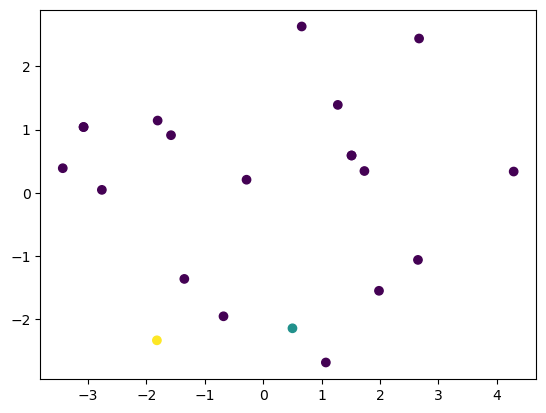

In [67]:
plt.scatter(x_pca[:,0], x_pca[:,1], c=df_encoded_no_na['fighter1_result'])

### Neural Network: Deep Learning with Keras & Tensorflow??